In [1]:
import pandas as pd

In [2]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
data_dir = '../data/data_preprocessed/msp_podcast/metadata/'

In [5]:
df = pd.read_csv(f'{data_dir}data.csv')

In [6]:
df

,filename,emotion,speaker,gender
0,MSP-PODCAST_0001_0008.wav,neutral,30,male
1,MSP-PODCAST_0001_0009.wav,neutral,39,male
2,MSP-PODCAST_0001_0011.wav,neutral,39,male
3,MSP-PODCAST_0001_0013.wav,neutral,39,male
4,MSP-PODCAST_0001_0016.wav,neutral,30,male
...,...,...,...,...
73037,MSP-PODCAST_2102_0142.wav,neutral,146,female
73038,MSP-PODCAST_2102_0195.wav,neutral,1164,female
73039,MSP-PODCAST_2104_0816.wav,neutral,Unknown,unknown
73040,MSP-PODCAST_2104_2311.wav,neutral,97,male


In [7]:
audio_dir = '../data/MSP_PODCAST/Audios/'

In [8]:
df['emotion'].value_counts()

emotion
neutral         26009
happiness       14285
no_agreement    14199
surprise         4084
contempt         3644
anger            3218
sadness          2649
disgust          2593
fear             1544
other             817
Name: count, dtype: int64

In [10]:
labels = ['ang', 'neu', 'sad', 'hap']

In [11]:
df = df[df['emotion'].apply(lambda x: x[:3] in labels)]
df['emotion'].value_counts()

emotion
neutral      26009
happiness    14285
anger         3218
sadness       2649
Name: count, dtype: int64

In [12]:
df[df['speaker']=='Unknown']['emotion'].value_counts()

emotion
neutral      2774
happiness    1310
anger         371
sadness       322
Name: count, dtype: int64

In [13]:
df[df['speaker']!='Unknown']['emotion'].value_counts()

emotion
neutral      23235
happiness    12975
anger         2847
sadness       2327
Name: count, dtype: int64

In [13]:
df[df['emotion']=='neutral'][:4000]

,filename,emotion,speaker,gender
0,MSP-PODCAST_0001_0008.wav,neutral,30,male
1,MSP-PODCAST_0001_0009.wav,neutral,39,male
2,MSP-PODCAST_0001_0011.wav,neutral,39,male
3,MSP-PODCAST_0001_0013.wav,neutral,39,male
4,MSP-PODCAST_0001_0016.wav,neutral,30,male
...,...,...,...,...
8863,MSP-PODCAST_0214_0918.wav,neutral,80,male
8872,MSP-PODCAST_0215_0012.wav,neutral,119,male
8873,MSP-PODCAST_0215_0013.wav,neutral,Unknown,unknown
8874,MSP-PODCAST_0215_0016.wav,neutral,119,male


In [15]:
df[df['emotion']=='happiness'][:4000]

,filename,emotion,speaker,gender
5,MSP-PODCAST_0001_0019.wav,happiness,30,male
6,MSP-PODCAST_0001_0020.wav,happiness,30,male
8,MSP-PODCAST_0001_0025.wav,happiness,30,male
21,MSP-PODCAST_0001_0060.wav,happiness,39,male
23,MSP-PODCAST_0001_0062.wav,happiness,39,male
...,...,...,...,...
19619,MSP-PODCAST_0593_0081.wav,happiness,130,female
19625,MSP-PODCAST_0593_0145.wav,happiness,131,female
19631,MSP-PODCAST_0593_0197.wav,happiness,130,female
19645,MSP-PODCAST_0593_0440.wav,happiness,130,female


In [18]:
df_selected = pd.concat([
    df[df['emotion'].isin(['anger', 'sadness'])],
    df[df['emotion']=='neutral'][:4000],
    df[df['emotion']=='happiness'][:4000]])

In [19]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [20]:
import soundfile as sf

In [21]:
def load_audio(filename):
    waveform, sample_rate = sf.read(f'{audio_dir}{filename}') 
    return waveform

In [22]:
df_selected['audio'] = df_selected['filename'].apply(load_audio)

In [23]:
df_selected['audio'].apply(lambda x: len(x.shape)).value_counts()

audio
1    13866
2        1
Name: count, dtype: int64

In [24]:
df_selected = df_selected[df_selected['audio'].apply(lambda x: len(x.shape)==1)]

In [25]:
df_selected['audio'].apply(lambda x: len(x.shape)).value_counts()

audio
1    13866
Name: count, dtype: int64

In [26]:
data_x = df_selected['audio'].to_list()
data_y = df_selected['emotion'].to_list()

In [55]:
feature_dir = '../data/data_preprocessed/msp_podcast/features_4balanced/'

In [57]:
np.save(f'{feature_dir}msp_podcast.audio16k.npy', 
        np.array(data_x, dtype=object), allow_pickle=True)

In [60]:
np.save(f'{feature_dir}msp_podcast.label_emotion.npy', 
        np.array(data_y, dtype=str), allow_pickle=True)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 11092
Test: 2774


In [71]:
np.save(f'{feature_dir}msp_podcast.audio16k.train.npy', 
        np.array(x_train, dtype=object), allow_pickle=True)
np.save(f'{feature_dir}msp_podcast.audio16k.test.npy', 
        np.array(x_test, dtype=object), allow_pickle=True)
np.save(f'{feature_dir}msp_podcast.label_emotion.train.npy', 
        np.array(y_train, dtype=object), allow_pickle=True)
np.save(f'{feature_dir}msp_podcast.label_emotion.test.npy', 
        np.array(y_test, dtype=object), allow_pickle=True)

In [28]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [29]:
sr = 16000

def label_to_index(word):
    return labels.index(word[:3])

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).flatten(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [30]:
import traceback

In [31]:
from IConNet.nn.model import M18
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m18.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M18(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M18', 'description': 'FirConv sequential for speech emotion', 'fe': {'n_block': 2, 'n_channel': [129, 30], 'kernel_size': [127, 63], 'stride': [2, 8], 'window_k': [5, 9], 'mel_resolution': 3, 'residual_connection_type': 'stack', 'pooling': False, 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 1, 'n_channel': 32, 'out_seq_length': 8, 'use_context': True, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm', 'dropout': 0.1}}


M18(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2MBlocks(
    (blocks): LSTM(160, 32, batch_first=True)
    (pad_layer)

In [32]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [33]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [34]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                         | 0.0011547344110854503/10 [00:00<1:56:48, 700.94s/it]

Train Epoch: 1 [0/11092 (0%)]	Loss: 1.644561
Mem before-during-after: 3254784 3503168000 36957696


  0%|▏                            | 0.04734411085450344/10 [00:13<50:43, 305.75s/it]

Train Epoch: 1 [640/11092 (6%)]	Loss: 1.668750
Mem before-during-after: 37242880 3522677248 37242880


  1%|▎                            | 0.09353348729792137/10 [00:26<50:31, 306.03s/it]

Train Epoch: 1 [1280/11092 (12%)]	Loss: 1.195945
Mem before-during-after: 37242880 3521694720 37111808


  1%|▍                            | 0.13972286374133946/10 [00:38<49:56, 303.94s/it]

Train Epoch: 1 [1920/11092 (17%)]	Loss: 1.405443
Mem before-during-after: 37111808 3522330624 37242880


  2%|▌                            | 0.18591224018475794/10 [00:51<50:13, 307.02s/it]

Train Epoch: 1 [2560/11092 (23%)]	Loss: 1.346381
Mem before-during-after: 37242880 3522677248 37242880


  2%|▋                            | 0.23325635103926187/10 [01:04<42:43, 262.44s/it]

Train Epoch: 1 [3200/11092 (29%)]	Loss: 1.400562
Mem before-during-after: 37242880 3521694720 37111808


  3%|▊                            | 0.27944572748267965/10 [01:17<42:45, 263.97s/it]

Train Epoch: 1 [3840/11092 (35%)]	Loss: 1.435326
Mem before-during-after: 37111808 3522330624 37242880


  3%|▉                             | 0.3244803695150116/10 [01:29<50:17, 311.88s/it]

Train Epoch: 1 [4480/11092 (40%)]	Loss: 1.434684
Mem before-during-after: 37242880 3522677248 37242880


  4%|█                             | 0.3718244803695144/10 [01:42<42:43, 266.21s/it]

Train Epoch: 1 [5120/11092 (46%)]	Loss: 1.124623
Mem before-during-after: 37242880 3521694720 37111808


  4%|█▏                           | 0.41801385681293174/10 [01:55<42:23, 265.49s/it]

Train Epoch: 1 [5760/11092 (52%)]	Loss: 1.445570
Mem before-during-after: 37111808 3522330624 37242880


  5%|█▍                            | 0.4642032332563491/10 [02:07<42:02, 264.58s/it]

Train Epoch: 1 [6400/11092 (58%)]	Loss: 1.819323
Mem before-during-after: 37242880 3522677248 37242880


  5%|█▌                             | 0.510392609699767/10 [02:20<41:53, 264.84s/it]

Train Epoch: 1 [7040/11092 (63%)]	Loss: 1.349288
Mem before-during-after: 37242880 3521694720 37111808


  6%|█▋                            | 0.5554272517321011/10 [02:32<49:10, 312.41s/it]

Train Epoch: 1 [7680/11092 (69%)]	Loss: 1.316705
Mem before-during-after: 37111808 3522330624 37242880


  6%|█▊                            | 0.6016166281755206/10 [02:45<48:44, 311.18s/it]

Train Epoch: 1 [8320/11092 (75%)]	Loss: 1.280111
Mem before-during-after: 37242880 3522677248 37242880


  6%|█▉                            | 0.6489607390300257/10 [02:58<42:05, 270.11s/it]

Train Epoch: 1 [8960/11092 (81%)]	Loss: 1.556096
Mem before-during-after: 37242880 3521694720 37111808


  7%|██                            | 0.6939953810623598/10 [03:10<47:14, 304.60s/it]

Train Epoch: 1 [9600/11092 (87%)]	Loss: 1.563324
Mem before-during-after: 37111808 3522330624 37242880


  7%|██▏                           | 0.7401847575057794/10 [03:23<46:59, 304.48s/it]

Train Epoch: 1 [10240/11092 (92%)]	Loss: 1.353881
Mem before-during-after: 37242880 3522677248 37242880


  8%|██▎                           | 0.7875288683602845/10 [03:36<42:33, 277.22s/it]

Train Epoch: 1 [10880/11092 (98%)]	Loss: 1.573452
Mem before-during-after: 37242880 3521694720 37111808


 10%|███                           | 1.0000000000000144/10 [04:12<23:57, 159.73s/it]


Test Epoch: 1	Accuracy: 872/2768 (31%)



 10%|███                           | 1.0011547344110998/10 [04:12<29:16, 195.23s/it]

Train Epoch: 2 [0/11092 (0%)]	Loss: 1.232274
Mem before-during-after: 37238784 3521754112 37365760


 10%|███▏                           | 1.047344110854515/10 [04:25<45:38, 305.86s/it]

Train Epoch: 2 [640/11092 (6%)]	Loss: 1.231472
Mem before-during-after: 37242880 3521694720 37111808


 11%|███▎                          | 1.0946882217090155/10 [04:38<39:13, 264.34s/it]

Train Epoch: 2 [1280/11092 (12%)]	Loss: 1.228538
Mem before-during-after: 37111808 3522330624 37242880


 11%|███▍                          | 1.1408775981524306/10 [04:51<39:43, 269.01s/it]

Train Epoch: 2 [1920/11092 (17%)]	Loss: 1.524858
Mem before-during-after: 37242880 3522677248 37242880


 12%|███▌                          | 1.1870669745958458/10 [05:04<39:35, 269.56s/it]

Train Epoch: 2 [2560/11092 (23%)]	Loss: 1.331415
Mem before-during-after: 37229056 3522876928 37097984


 12%|███▊                           | 1.233256351039261/10 [05:16<38:37, 264.36s/it]

Train Epoch: 2 [3200/11092 (29%)]	Loss: 1.248605
Mem before-during-after: 37242880 3521694720 37111808


 13%|███▉                           | 1.279445727482676/10 [05:29<38:23, 264.19s/it]

Train Epoch: 2 [3840/11092 (35%)]	Loss: 1.389068
Mem before-during-after: 37111808 3522330624 37242880


 13%|███▉                          | 1.3256351039260912/10 [05:41<38:36, 267.08s/it]

Train Epoch: 2 [4480/11092 (40%)]	Loss: 1.294859
Mem before-during-after: 37242880 3522677248 37242880


 14%|████                          | 1.3718244803695063/10 [05:54<37:52, 263.36s/it]

Train Epoch: 2 [5120/11092 (46%)]	Loss: 1.272868
Mem before-during-after: 37242880 3521694720 37111808


 14%|████▍                          | 1.416859122401836/10 [06:07<43:37, 304.94s/it]

Train Epoch: 2 [5760/11092 (52%)]	Loss: 1.292547
Mem before-during-after: 37111808 3522330624 37242880


 15%|████▍                         | 1.4642032332563366/10 [06:19<37:20, 262.53s/it]

Train Epoch: 2 [6400/11092 (58%)]	Loss: 1.389631
Mem before-during-after: 37242880 3522677248 37242880


 15%|████▌                         | 1.5103926096997518/10 [06:32<37:21, 264.07s/it]

Train Epoch: 2 [7040/11092 (63%)]	Loss: 1.186535
Mem before-during-after: 37242880 3521694720 37111808


 16%|████▊                          | 1.556581986143167/10 [06:44<38:33, 274.05s/it]

Train Epoch: 2 [7680/11092 (69%)]	Loss: 1.233942
Mem before-during-after: 37111808 3522330624 37242880


 16%|████▊                         | 1.6016166281754967/10 [06:57<42:40, 304.88s/it]

Train Epoch: 2 [8320/11092 (75%)]	Loss: 1.589083
Mem before-during-after: 37242880 3522677248 37242880


 16%|████▉                         | 1.6478060046189118/10 [07:09<42:48, 307.58s/it]

Train Epoch: 2 [8960/11092 (81%)]	Loss: 1.406446
Mem before-during-after: 37242880 3521694720 37111808


 17%|█████▎                         | 1.693995381062327/10 [07:22<42:29, 306.94s/it]

Train Epoch: 2 [9600/11092 (87%)]	Loss: 1.331675
Mem before-during-after: 37111808 3522330624 37242880


 17%|█████▍                         | 1.740184757505742/10 [07:35<42:15, 306.91s/it]

Train Epoch: 2 [10240/11092 (92%)]	Loss: 1.728995
Mem before-during-after: 37242880 3522677248 37242880


 18%|█████▎                        | 1.7863741339491572/10 [07:47<41:47, 305.30s/it]

Train Epoch: 2 [10880/11092 (98%)]	Loss: 1.131343
Mem before-during-after: 37242880 3521694720 37111808


 20%|█████▉                        | 1.9999999999999523/10 [08:24<21:39, 162.40s/it]


Test Epoch: 2	Accuracy: 837/2768 (30%)



 20%|██████▏                        | 2.001154734411038/10 [08:24<28:35, 214.44s/it]

Train Epoch: 3 [0/11092 (0%)]	Loss: 1.479290
Mem before-during-after: 37238784 3521754112 37365760


 20%|██████▏                       | 2.0484988452655384/10 [08:37<35:13, 265.83s/it]

Train Epoch: 3 [640/11092 (6%)]	Loss: 1.284847
Mem before-during-after: 37242880 3521694720 37111808


 21%|██████▎                       | 2.0946882217089535/10 [08:50<34:53, 264.78s/it]

Train Epoch: 3 [1280/11092 (12%)]	Loss: 1.432460
Mem before-during-after: 37111808 3522330624 37242880


 21%|██████▍                       | 2.1408775981523687/10 [09:02<34:32, 263.66s/it]

Train Epoch: 3 [1920/11092 (17%)]	Loss: 1.375116
Mem before-during-after: 37242880 3522677248 37242880


 22%|██████▊                        | 2.187066974595784/10 [09:15<34:19, 263.57s/it]

Train Epoch: 3 [2560/11092 (23%)]	Loss: 1.345239
Mem before-during-after: 37242880 3521694720 37111808


 22%|██████▉                        | 2.233256351039199/10 [09:28<33:56, 262.23s/it]

Train Epoch: 3 [3200/11092 (29%)]	Loss: 1.361820
Mem before-during-after: 37111808 3522330624 37242880


 23%|███████                        | 2.279445727482614/10 [09:40<33:55, 263.69s/it]

Train Epoch: 3 [3840/11092 (35%)]	Loss: 1.437262
Mem before-during-after: 37242880 3522677248 37242880


 23%|██████▉                       | 2.3256351039260292/10 [09:53<34:00, 265.91s/it]

Train Epoch: 3 [4480/11092 (40%)]	Loss: 1.511749
Mem before-during-after: 37242880 3521694720 37111808


 24%|███████▎                       | 2.370669745958359/10 [10:05<39:26, 310.17s/it]

Train Epoch: 3 [5120/11092 (46%)]	Loss: 1.319179
Mem before-during-after: 37111808 3522330624 37242880


 24%|███████▍                       | 2.416859122401774/10 [10:18<38:39, 305.86s/it]

Train Epoch: 3 [5760/11092 (52%)]	Loss: 1.280743
Mem before-during-after: 37242880 3522677248 37242880


 25%|███████▍                      | 2.4642032332562747/10 [10:31<33:35, 267.50s/it]

Train Epoch: 3 [6400/11092 (58%)]	Loss: 1.133912
Mem before-during-after: 37242880 3521694720 37111808


 25%|███████▌                      | 2.5092378752886044/10 [10:43<39:58, 320.19s/it]

Train Epoch: 3 [7040/11092 (63%)]	Loss: 1.376851
Mem before-during-after: 37111808 3522330624 37242880


 26%|███████▋                      | 2.5554272517320196/10 [10:57<38:24, 309.61s/it]

Train Epoch: 3 [7680/11092 (69%)]	Loss: 1.423733
Mem before-during-after: 37242880 3522677248 37242880


 26%|████████▎                       | 2.60277136258652/10 [11:10<31:59, 259.55s/it]

Train Epoch: 3 [8320/11092 (75%)]	Loss: 1.405321
Mem before-during-after: 37242880 3521694720 37111808


 26%|███████▉                      | 2.6489607390299352/10 [11:23<31:57, 260.80s/it]

Train Epoch: 3 [8960/11092 (81%)]	Loss: 1.428015
Mem before-during-after: 37111808 3522330624 37242880


 27%|████████▎                      | 2.693995381062265/10 [11:35<37:22, 306.89s/it]

Train Epoch: 3 [9600/11092 (87%)]	Loss: 1.361853
Mem before-during-after: 37242880 3522677248 37242880


 27%|████████▊                       | 2.74018475750568/10 [11:48<37:44, 311.89s/it]

Train Epoch: 3 [10240/11092 (92%)]	Loss: 1.423427
Mem before-during-after: 37242880 3521694720 37111808


 28%|████████▎                     | 2.7875288683601807/10 [12:01<31:45, 264.13s/it]

Train Epoch: 3 [10880/11092 (98%)]	Loss: 1.224356
Mem before-during-after: 37111808 3522330624 37242880


 30%|████████▉                     | 2.9999999999998903/10 [12:37<19:04, 163.51s/it]


Test Epoch: 3	Accuracy: 919/2768 (33%)



 30%|█████████▎                     | 3.002309468822061/10 [12:38<22:02, 188.96s/it]

Train Epoch: 4 [0/11092 (0%)]	Loss: 1.312818
Mem before-during-after: 37238784 3521754112 37365760


 30%|█████████▍                     | 3.048498845265476/10 [12:50<30:24, 262.45s/it]

Train Epoch: 4 [640/11092 (6%)]	Loss: 1.334049
Mem before-during-after: 37242880 3521694720 37111808


 31%|█████████▎                    | 3.0946882217088914/10 [13:03<30:19, 263.45s/it]

Train Epoch: 4 [1280/11092 (12%)]	Loss: 1.082788
Mem before-during-after: 37111808 3522330624 37242880


 31%|█████████▋                     | 3.139722863741221/10 [13:16<34:36, 302.75s/it]

Train Epoch: 4 [1920/11092 (17%)]	Loss: 1.579791
Mem before-during-after: 37242880 3522677248 37242880


 32%|█████████▌                    | 3.1859122401846363/10 [13:28<35:24, 311.75s/it]

Train Epoch: 4 [2560/11092 (23%)]	Loss: 1.274066
Mem before-during-after: 37242880 3521694720 37111808


 32%|█████████▋                    | 3.2332563510391368/10 [13:41<30:31, 270.72s/it]

Train Epoch: 4 [3200/11092 (29%)]	Loss: 1.331791
Mem before-during-after: 37111808 3522330624 37242880


 33%|██████████▏                    | 3.279445727482552/10 [13:54<29:19, 261.85s/it]

Train Epoch: 4 [3840/11092 (35%)]	Loss: 1.175466
Mem before-during-after: 37242880 3522677248 37242880


 33%|██████████▎                    | 3.325635103925967/10 [14:06<29:46, 267.66s/it]

Train Epoch: 4 [4480/11092 (40%)]	Loss: 1.129185
Mem before-during-after: 37242880 3521694720 37111808


 34%|██████████▍                    | 3.370669745958297/10 [14:20<38:10, 345.51s/it]

Train Epoch: 4 [5120/11092 (46%)]	Loss: 1.294728
Mem before-during-after: 37111808 3522330624 37242880


 34%|██████████▌                    | 3.416859122401712/10 [14:33<42:32, 387.68s/it]

Train Epoch: 4 [5760/11092 (52%)]	Loss: 1.283913
Mem before-during-after: 37242880 3522677248 37242880


 35%|██████████▍                   | 3.4642032332562125/10 [14:46<29:32, 271.17s/it]

Train Epoch: 4 [6400/11092 (58%)]	Loss: 1.492199
Mem before-during-after: 37242880 3521694720 37111808


 35%|██████████▌                   | 3.5092378752885423/10 [14:59<34:16, 316.80s/it]

Train Epoch: 4 [7040/11092 (63%)]	Loss: 1.100894
Mem before-during-after: 37111808 3522330624 37242880


 36%|██████████▋                   | 3.5554272517319574/10 [15:12<32:52, 306.02s/it]

Train Epoch: 4 [7680/11092 (69%)]	Loss: 1.334932
Mem before-during-after: 37242880 3522677248 37242880


 36%|███████████▏                   | 3.602771362586458/10 [15:25<28:13, 264.72s/it]

Train Epoch: 4 [8320/11092 (75%)]	Loss: 1.241474
Mem before-during-after: 37242880 3521694720 37111808


 36%|███████████▎                   | 3.648960739029873/10 [15:38<28:13, 266.73s/it]

Train Epoch: 4 [8960/11092 (81%)]	Loss: 1.237969
Mem before-during-after: 37111808 3522330624 37242880


 37%|███████████▍                   | 3.695150115473288/10 [15:51<27:40, 263.36s/it]

Train Epoch: 4 [9600/11092 (87%)]	Loss: 1.472605
Mem before-during-after: 37242880 3522677248 37242880


 37%|███████████▌                   | 3.740184757505618/10 [16:04<32:54, 315.42s/it]

Train Epoch: 4 [10240/11092 (92%)]	Loss: 1.184056
Mem before-during-after: 37242880 3521694720 37111808


 38%|███████████▋                   | 3.786374133949033/10 [16:16<31:54, 308.07s/it]

Train Epoch: 4 [10880/11092 (98%)]	Loss: 1.407948
Mem before-during-after: 37111808 3522330624 37242880


 40%|████████████▍                  | 3.999999999999828/10 [16:54<16:15, 162.64s/it]


Test Epoch: 4	Accuracy: 879/2768 (32%)



 40%|████████████▍                  | 4.001154734410914/10 [16:54<19:29, 194.96s/it]

Train Epoch: 5 [0/11092 (0%)]	Loss: 1.417018
Mem before-during-after: 37238784 3521754112 37365760


 40%|████████████▏                 | 4.0484988452654145/10 [17:07<27:04, 272.96s/it]

Train Epoch: 5 [640/11092 (6%)]	Loss: 1.277574
Mem before-during-after: 37242880 3521694720 37111808


 41%|█████████████                   | 4.09468822170883/10 [17:20<26:31, 269.54s/it]

Train Epoch: 5 [1280/11092 (12%)]	Loss: 1.285279
Mem before-during-after: 37111808 3522330624 37242880


 41%|████████████▊                  | 4.140877598152245/10 [17:33<25:27, 260.64s/it]

Train Epoch: 5 [1920/11092 (17%)]	Loss: 1.302812
Mem before-during-after: 37242880 3522677248 37242880


 42%|████████████▌                 | 4.1859122401845745/10 [17:46<29:39, 306.08s/it]

Train Epoch: 5 [2560/11092 (23%)]	Loss: 1.296594
Mem before-during-after: 37242880 3521694720 37111808


 42%|█████████████                  | 4.233256351039075/10 [17:58<25:13, 262.46s/it]

Train Epoch: 5 [3200/11092 (29%)]	Loss: 1.130004
Mem before-during-after: 37111808 3522330624 37242880


 43%|█████████████▋                  | 4.27944572748249/10 [18:11<24:48, 260.25s/it]

Train Epoch: 5 [3840/11092 (35%)]	Loss: 1.300275
Mem before-during-after: 37242880 3522677248 37242880


 43%|█████████████▊                  | 4.32448036951482/10 [18:23<28:38, 302.74s/it]

Train Epoch: 5 [4480/11092 (40%)]	Loss: 1.301314
Mem before-during-after: 37242880 3521694720 37111808


 44%|█████████████▌                 | 4.370669745958235/10 [18:36<30:39, 326.81s/it]

Train Epoch: 5 [5120/11092 (46%)]	Loss: 1.139544
Mem before-during-after: 37111808 3522330624 37242880


 44%|█████████████▋                 | 4.418013856812736/10 [18:49<26:34, 285.66s/it]

Train Epoch: 5 [5760/11092 (52%)]	Loss: 1.317374
Mem before-during-after: 37242880 3522677248 37242880


 45%|█████████████▊                 | 4.464203233256151/10 [19:02<24:09, 261.76s/it]

Train Epoch: 5 [6400/11092 (58%)]	Loss: 1.231655
Mem before-during-after: 37242880 3521694720 37111808


 45%|█████████████▉                 | 4.510392609699566/10 [19:14<23:48, 260.14s/it]

Train Epoch: 5 [7040/11092 (63%)]	Loss: 1.492755
Mem before-during-after: 37111808 3522330624 37242880


 46%|██████████████▏                | 4.556581986142981/10 [19:27<24:14, 267.12s/it]

Train Epoch: 5 [7680/11092 (69%)]	Loss: 1.144006
Mem before-during-after: 37242880 3522677248 37242880


 46%|██████████████▎                | 4.602771362586396/10 [19:39<23:25, 260.34s/it]

Train Epoch: 5 [8320/11092 (75%)]	Loss: 1.332493
Mem before-during-after: 37242880 3521694720 37111808


 46%|██████████████▍                | 4.648960739029811/10 [19:52<23:25, 262.66s/it]

Train Epoch: 5 [8960/11092 (81%)]	Loss: 1.327418
Mem before-during-after: 37111808 3522330624 37242880


 47%|██████████████▌                | 4.693995381062141/10 [20:05<27:51, 315.06s/it]

Train Epoch: 5 [9600/11092 (87%)]	Loss: 1.214800
Mem before-during-after: 37242880 3522677248 37242880


 47%|██████████████▋                | 4.741339491916642/10 [20:17<23:10, 264.51s/it]

Train Epoch: 5 [10240/11092 (92%)]	Loss: 1.298587
Mem before-during-after: 37242880 3521694720 37111808


 48%|██████████████▊                | 4.787528868360057/10 [20:30<23:09, 266.53s/it]

Train Epoch: 5 [10880/11092 (98%)]	Loss: 1.348491
Mem before-during-after: 37111808 3522330624 37242880


 50%|███████████████▍               | 4.999999999999766/10 [21:07<13:36, 163.36s/it]


Test Epoch: 5	Accuracy: 862/2768 (31%)



 50%|███████████████▌               | 5.001154734410852/10 [21:07<16:30, 198.12s/it]

Train Epoch: 6 [0/11092 (0%)]	Loss: 1.280481
Mem before-during-after: 37238784 3521754112 37365760


 50%|███████████████▋               | 5.048498845265352/10 [21:20<21:38, 262.15s/it]

Train Epoch: 6 [640/11092 (6%)]	Loss: 1.320342
Mem before-during-after: 37242880 3521694720 37111808


 51%|███████████████▎              | 5.0946882217087675/10 [21:33<22:06, 270.33s/it]

Train Epoch: 6 [1280/11092 (12%)]	Loss: 1.303632
Mem before-during-after: 37111808 3522330624 37242880


 51%|███████████████▉               | 5.140877598152183/10 [21:45<21:19, 263.23s/it]

Train Epoch: 6 [1920/11092 (17%)]	Loss: 1.455353
Mem before-during-after: 37242880 3522677248 37242880


 52%|████████████████               | 5.187066974595598/10 [21:58<21:04, 262.71s/it]

Train Epoch: 6 [2560/11092 (23%)]	Loss: 1.200249
Mem before-during-after: 37242880 3521694720 37111808


 52%|████████████████▏              | 5.233256351039013/10 [22:11<20:45, 261.26s/it]

Train Epoch: 6 [3200/11092 (29%)]	Loss: 1.344993
Mem before-during-after: 37111808 3522330624 37242880


 53%|████████████████▎              | 5.278290993071343/10 [22:23<24:35, 312.59s/it]

Train Epoch: 6 [3840/11092 (35%)]	Loss: 1.234320
Mem before-during-after: 37242880 3522677248 37242880


 53%|████████████████▌              | 5.324480369514758/10 [22:36<24:08, 309.85s/it]

Train Epoch: 6 [4480/11092 (40%)]	Loss: 1.165078
Mem before-during-after: 37242880 3521694720 37111808


 54%|████████████████▋              | 5.371824480369258/10 [22:49<20:18, 263.34s/it]

Train Epoch: 6 [5120/11092 (46%)]	Loss: 1.383886
Mem before-during-after: 37111808 3522330624 37242880


 54%|████████████████▊              | 5.416859122401588/10 [23:02<23:23, 306.23s/it]

Train Epoch: 6 [5760/11092 (52%)]	Loss: 1.305584
Mem before-during-after: 37242880 3522677248 37242880


 55%|████████████████▉              | 5.463048498845003/10 [23:15<24:59, 330.51s/it]

Train Epoch: 6 [6400/11092 (58%)]	Loss: 1.258346
Mem before-during-after: 37242880 3521694720 37111808


 55%|█████████████████              | 5.510392609699504/10 [23:28<20:21, 272.16s/it]

Train Epoch: 6 [7040/11092 (63%)]	Loss: 1.310832
Mem before-during-after: 37111808 3522330624 37242880


 56%|█████████████████▏             | 5.556581986142919/10 [23:41<19:27, 262.80s/it]

Train Epoch: 6 [7680/11092 (69%)]	Loss: 1.458329
Mem before-during-after: 37242880 3522677248 37242880


 56%|█████████████████▎             | 5.602771362586334/10 [23:54<19:13, 262.36s/it]

Train Epoch: 6 [8320/11092 (75%)]	Loss: 1.299147
Mem before-during-after: 37242880 3521694720 37111808


 56%|█████████████████▌             | 5.648960739029749/10 [24:06<19:05, 263.31s/it]

Train Epoch: 6 [8960/11092 (81%)]	Loss: 1.253268
Mem before-during-after: 37111808 3522330624 37242880


 57%|█████████████████▋             | 5.693995381062079/10 [24:19<22:25, 312.39s/it]

Train Epoch: 6 [9600/11092 (87%)]	Loss: 1.268941
Mem before-during-after: 37242880 3522677248 37242880


 57%|█████████████████▊             | 5.741339491916579/10 [24:31<18:39, 262.90s/it]

Train Epoch: 6 [10240/11092 (92%)]	Loss: 1.238589
Mem before-during-after: 37242880 3521694720 37111808


 58%|█████████████████▉             | 5.787528868359995/10 [24:45<18:38, 265.59s/it]

Train Epoch: 6 [10880/11092 (98%)]	Loss: 1.313158
Mem before-during-after: 37111808 3522330624 37242880


 60%|██████████████████▌            | 5.999999999999704/10 [25:22<10:38, 159.73s/it]


Test Epoch: 6	Accuracy: 906/2768 (33%)



 60%|██████████████████▌            | 6.002309468821875/10 [25:23<12:12, 183.34s/it]

Train Epoch: 7 [0/11092 (0%)]	Loss: 1.160138
Mem before-during-after: 37238784 3521754112 37365760


 60%|███████████████████▎            | 6.04849884526529/10 [25:35<17:15, 262.01s/it]

Train Epoch: 7 [640/11092 (6%)]	Loss: 1.203946
Mem before-during-after: 37242880 3521694720 37111808


 61%|██████████████████▉            | 6.094688221708705/10 [25:48<17:11, 264.25s/it]

Train Epoch: 7 [1280/11092 (12%)]	Loss: 1.241091
Mem before-during-after: 37111808 3522330624 37242880


 61%|███████████████████▋            | 6.14087759815212/10 [26:00<17:33, 273.09s/it]

Train Epoch: 7 [1920/11092 (17%)]	Loss: 1.269814
Mem before-during-after: 37242880 3522677248 37242880


 62%|███████████████████▏           | 6.187066974595536/10 [26:13<16:55, 266.21s/it]

Train Epoch: 7 [2560/11092 (23%)]	Loss: 1.358629
Mem before-during-after: 37242880 3521694720 37111808


 62%|███████████████████▎           | 6.233256351038951/10 [26:26<17:19, 275.95s/it]

Train Epoch: 7 [3200/11092 (29%)]	Loss: 1.508799
Mem before-during-after: 37111808 3522330624 37242880


 63%|██████████████████▊           | 6.2782909930712805/10 [26:38<19:08, 308.71s/it]

Train Epoch: 7 [3840/11092 (35%)]	Loss: 1.307478
Mem before-during-after: 37242880 3522677248 37242880


 63%|███████████████████▌           | 6.324480369514696/10 [26:51<18:44, 306.04s/it]

Train Epoch: 7 [4480/11092 (40%)]	Loss: 1.334340
Mem before-during-after: 37242880 3521694720 37111808


 64%|███████████████████▊           | 6.371824480369196/10 [27:04<15:53, 262.88s/it]

Train Epoch: 7 [5120/11092 (46%)]	Loss: 1.249448
Mem before-during-after: 37111808 3522330624 37242880


 64%|███████████████████▉           | 6.418013856812611/10 [27:17<15:41, 262.95s/it]

Train Epoch: 7 [5760/11092 (52%)]	Loss: 1.351436
Mem before-during-after: 37242880 3522677248 37242880


 65%|████████████████████           | 6.463048498844941/10 [27:29<17:54, 303.89s/it]

Train Epoch: 7 [6400/11092 (58%)]	Loss: 1.419091
Mem before-during-after: 37242880 3521694720 37111808


 65%|████████████████████▏          | 6.509237875288356/10 [27:42<17:38, 303.36s/it]

Train Epoch: 7 [7040/11092 (63%)]	Loss: 1.327055
Mem before-during-after: 37111808 3522330624 37242880


 66%|████████████████████▎          | 6.555427251731771/10 [27:54<17:27, 304.07s/it]

Train Epoch: 7 [7680/11092 (69%)]	Loss: 1.295660
Mem before-during-after: 37242880 3522677248 37242880


 66%|████████████████████▍          | 6.602771362586272/10 [28:07<14:44, 260.31s/it]

Train Epoch: 7 [8320/11092 (75%)]	Loss: 1.406102
Mem before-during-after: 37242880 3521694720 37111808


 66%|████████████████████▌          | 6.648960739029687/10 [28:19<14:40, 262.82s/it]

Train Epoch: 7 [8960/11092 (81%)]	Loss: 1.173351
Mem before-during-after: 37111808 3522330624 37242880


 67%|████████████████████▊          | 6.695150115473102/10 [28:32<14:18, 259.89s/it]

Train Epoch: 7 [9600/11092 (87%)]	Loss: 1.239180
Mem before-during-after: 37242880 3522677248 37242880


 67%|████████████████████▉          | 6.741339491916517/10 [28:44<14:17, 263.03s/it]

Train Epoch: 7 [10240/11092 (92%)]	Loss: 1.324788
Mem before-during-after: 37242880 3521694720 37111808


 68%|█████████████████████          | 6.787528868359932/10 [28:57<14:08, 264.22s/it]

Train Epoch: 7 [10880/11092 (98%)]	Loss: 1.335745
Mem before-during-after: 37111808 3522330624 37242880


 70%|█████████████████████▋         | 6.999999999999642/10 [29:33<08:01, 160.40s/it]


Test Epoch: 7	Accuracy: 927/2768 (33%)



 70%|█████████████████████▋         | 7.002309468821813/10 [29:34<09:24, 188.42s/it]

Train Epoch: 8 [0/11092 (0%)]	Loss: 1.295193
Mem before-during-after: 37238784 3521754112 37365760


 70%|█████████████████████▊         | 7.048498845265228/10 [29:46<12:54, 262.50s/it]

Train Epoch: 8 [640/11092 (6%)]	Loss: 1.367770
Mem before-during-after: 37242880 3521694720 37111808


 71%|█████████████████████▉         | 7.093533487297558/10 [29:59<14:40, 302.84s/it]

Train Epoch: 8 [1280/11092 (12%)]	Loss: 1.290303
Mem before-during-after: 37111808 3522330624 37242880


 71%|██████████████████████▏        | 7.139722863740973/10 [30:11<14:33, 305.41s/it]

Train Epoch: 8 [1920/11092 (17%)]	Loss: 1.230328
Mem before-during-after: 37242880 3522677248 37242880


 72%|██████████████████████▎        | 7.187066974595473/10 [30:24<12:15, 261.54s/it]

Train Epoch: 8 [2560/11092 (23%)]	Loss: 1.211780
Mem before-during-after: 37242880 3521694720 37111808


 72%|█████████████████████▋        | 7.2332563510388885/10 [30:37<12:08, 263.20s/it]

Train Epoch: 8 [3200/11092 (29%)]	Loss: 1.491958
Mem before-during-after: 37111808 3522330624 37242880


 73%|██████████████████████▌        | 7.278290993071218/10 [30:49<13:46, 303.69s/it]

Train Epoch: 8 [3840/11092 (35%)]	Loss: 1.302303
Mem before-during-after: 37242880 3522677248 37242880


 73%|██████████████████████▋        | 7.325635103925719/10 [31:02<11:46, 264.05s/it]

Train Epoch: 8 [4480/11092 (40%)]	Loss: 1.195390
Mem before-during-after: 37242880 3521694720 37111808


 74%|██████████████████████▊        | 7.370669745958049/10 [31:14<13:18, 303.78s/it]

Train Epoch: 8 [5120/11092 (46%)]	Loss: 1.321213
Mem before-during-after: 37111808 3522330624 37242880


 74%|██████████████████████▉        | 7.418013856812549/10 [31:27<11:28, 266.84s/it]

Train Epoch: 8 [5760/11092 (52%)]	Loss: 1.342127
Mem before-during-after: 37242880 3522677248 37242880


 75%|███████████████████████▏       | 7.463048498844879/10 [31:41<13:16, 313.84s/it]

Train Epoch: 8 [6400/11092 (58%)]	Loss: 1.296607
Mem before-during-after: 37242880 3521694720 37111808


 75%|███████████████████████▎       | 7.510392609699379/10 [31:54<11:03, 266.54s/it]

Train Epoch: 8 [7040/11092 (63%)]	Loss: 1.242441
Mem before-during-after: 37111808 3522330624 37242880


 76%|██████████████████████▋       | 7.5565819861427945/10 [32:07<10:56, 268.79s/it]

Train Epoch: 8 [7680/11092 (69%)]	Loss: 1.358851
Mem before-during-after: 37242880 3522677248 37242880


 76%|███████████████████████▌       | 7.601616628175124/10 [32:19<12:09, 304.14s/it]

Train Epoch: 8 [8320/11092 (75%)]	Loss: 1.270792
Mem before-during-after: 37242880 3521694720 37111808


 76%|███████████████████████▋       | 7.648960739029625/10 [32:33<10:47, 275.45s/it]

Train Epoch: 8 [8960/11092 (81%)]	Loss: 1.324240
Mem before-during-after: 37111808 3522330624 37242880


 77%|████████████████████████▌       | 7.69515011547304/10 [32:46<10:04, 262.35s/it]

Train Epoch: 8 [9600/11092 (87%)]	Loss: 1.283757
Mem before-during-after: 37242880 3522677248 37242880


 77%|███████████████████████▉       | 7.741339491916455/10 [32:58<09:51, 261.76s/it]

Train Epoch: 8 [10240/11092 (92%)]	Loss: 1.320757
Mem before-during-after: 37242880 3521694720 37111808


 78%|████████████████████████▉       | 7.78752886835987/10 [33:11<09:37, 261.09s/it]

Train Epoch: 8 [10880/11092 (98%)]	Loss: 1.471107
Mem before-during-after: 37111808 3522330624 37242880


 80%|█████████████████████████▌      | 7.99999999999958/10 [33:47<05:16, 158.48s/it]


Test Epoch: 8	Accuracy: 855/2768 (31%)



 80%|████████████████████████▊      | 8.002309468821752/10 [33:47<06:12, 186.33s/it]

Train Epoch: 9 [0/11092 (0%)]	Loss: 1.314664
Mem before-during-after: 37238784 3521754112 37365760


 80%|████████████████████████▉      | 8.048498845265202/10 [34:00<08:50, 271.98s/it]

Train Epoch: 9 [640/11092 (6%)]	Loss: 1.291758
Mem before-during-after: 37242880 3521694720 37111808


 81%|█████████████████████████      | 8.094688221708653/10 [34:13<08:27, 266.34s/it]

Train Epoch: 9 [1280/11092 (12%)]	Loss: 1.285626
Mem before-during-after: 37111808 3522330624 37242880


 81%|█████████████████████████▏     | 8.140877598152104/10 [34:26<08:04, 260.84s/it]

Train Epoch: 9 [1920/11092 (17%)]	Loss: 1.268830
Mem before-during-after: 37242880 3522677248 37242880


 82%|█████████████████████████▍     | 8.185912240184468/10 [34:39<09:12, 304.72s/it]

Train Epoch: 9 [2560/11092 (23%)]	Loss: 1.450695
Mem before-during-after: 37242880 3521694720 37111808


 82%|█████████████████████████▌     | 8.233256351039005/10 [34:51<07:46, 264.04s/it]

Train Epoch: 9 [3200/11092 (29%)]	Loss: 1.252227
Mem before-during-after: 37111808 3522330624 37242880


 83%|█████████████████████████▋     | 8.279445727482456/10 [35:04<07:39, 267.33s/it]

Train Epoch: 9 [3840/11092 (35%)]	Loss: 1.199737
Mem before-during-after: 37242880 3522677248 37242880


 83%|█████████████████████████▊     | 8.325635103925906/10 [35:17<07:25, 265.96s/it]

Train Epoch: 9 [4480/11092 (40%)]	Loss: 1.388941
Mem before-during-after: 37242880 3521694720 37111808


 84%|█████████████████████████▉     | 8.371824480369357/10 [35:30<07:07, 262.56s/it]

Train Epoch: 9 [5120/11092 (46%)]	Loss: 1.256077
Mem before-during-after: 37111808 3522330624 37242880


 84%|██████████████████████████     | 8.416859122401721/10 [35:42<08:01, 304.16s/it]

Train Epoch: 9 [5760/11092 (52%)]	Loss: 1.301799
Mem before-during-after: 37242880 3522677248 37242880


 85%|██████████████████████████▏    | 8.464203233256258/10 [35:55<06:42, 262.10s/it]

Train Epoch: 9 [6400/11092 (58%)]	Loss: 1.340909
Mem before-during-after: 37242880 3521694720 37111808


 85%|██████████████████████████▍    | 8.510392609699709/10 [36:07<06:33, 264.39s/it]

Train Epoch: 9 [7040/11092 (63%)]	Loss: 1.310759
Mem before-during-after: 37111808 3522330624 37242880


 86%|███████████████████████████▍    | 8.55658198614316/10 [36:20<06:20, 263.33s/it]

Train Epoch: 9 [7680/11092 (69%)]	Loss: 1.345621
Mem before-during-after: 37242880 3522677248 37242880


 86%|███████████████████████████▌    | 8.60277136258661/10 [36:32<06:06, 261.97s/it]

Train Epoch: 9 [8320/11092 (75%)]	Loss: 1.221728
Mem before-during-after: 37242880 3521694720 37111808


 86%|██████████████████████████▊    | 8.648960739030061/10 [36:45<05:55, 262.97s/it]

Train Epoch: 9 [8960/11092 (81%)]	Loss: 1.339122
Mem before-during-after: 37111808 3522330624 37242880


 87%|██████████████████████████▉    | 8.695150115473512/10 [36:58<05:45, 264.99s/it]

Train Epoch: 9 [9600/11092 (87%)]	Loss: 1.152150
Mem before-during-after: 37242880 3522677248 37242880


 87%|███████████████████████████    | 8.741339491916962/10 [37:11<05:44, 273.45s/it]

Train Epoch: 9 [10240/11092 (92%)]	Loss: 1.288476
Mem before-during-after: 37242880 3521694720 37111808


 88%|███████████████████████████▏   | 8.787528868360413/10 [37:23<05:22, 265.81s/it]

Train Epoch: 9 [10880/11092 (98%)]	Loss: 1.199453
Mem before-during-after: 37111808 3522330624 37242880


 90%|███████████████████████████▉   | 9.000000000000286/10 [38:00<02:45, 165.21s/it]


Test Epoch: 9	Accuracy: 881/2768 (32%)



 90%|███████████████████████████▉   | 9.002309468822459/10 [38:00<03:10, 191.06s/it]

Train Epoch: 10 [0/11092 (0%)]	Loss: 1.440638
Mem before-during-after: 37238784 3521754112 37365760


 90%|████████████████████████████▉   | 9.04849884526591/10 [38:13<04:11, 264.29s/it]

Train Epoch: 10 [640/11092 (6%)]	Loss: 1.229424
Mem before-during-after: 37242880 3521694720 37111808


 91%|████████████████████████████▏  | 9.093533487298274/10 [38:25<04:37, 306.44s/it]

Train Epoch: 10 [1280/11092 (12%)]	Loss: 1.337472
Mem before-during-after: 37111808 3522330624 37242880


 91%|████████████████████████████▎  | 9.139722863741724/10 [38:38<04:22, 305.52s/it]

Train Epoch: 10 [1920/11092 (17%)]	Loss: 1.237312
Mem before-during-after: 37242880 3522677248 37242880


 92%|████████████████████████████▍  | 9.185912240185175/10 [38:51<04:08, 305.06s/it]

Train Epoch: 10 [2560/11092 (23%)]	Loss: 1.262518
Mem before-during-after: 37242880 3521694720 37111808


 92%|████████████████████████████▌  | 9.232101616628626/10 [39:03<03:53, 304.44s/it]

Train Epoch: 10 [3200/11092 (29%)]	Loss: 1.179047
Mem before-during-after: 37111808 3522330624 37242880


 93%|████████████████████████████▊  | 9.279445727483163/10 [39:16<03:10, 263.96s/it]

Train Epoch: 10 [3840/11092 (35%)]	Loss: 1.440541
Mem before-during-after: 37242880 3522677248 37242880


 93%|████████████████████████████▉  | 9.325635103926613/10 [39:29<02:54, 258.88s/it]

Train Epoch: 10 [4480/11092 (40%)]	Loss: 1.292431
Mem before-during-after: 37242880 3521694720 37111808


 94%|█████████████████████████████  | 9.371824480370064/10 [39:42<02:45, 264.24s/it]

Train Epoch: 10 [5120/11092 (46%)]	Loss: 1.225055
Mem before-during-after: 37111808 3522330624 37242880


 94%|█████████████████████████████▏ | 9.418013856813515/10 [39:54<02:31, 261.14s/it]

Train Epoch: 10 [5760/11092 (52%)]	Loss: 1.255291
Mem before-during-after: 37242880 3522677248 37242880


 95%|█████████████████████████████▎ | 9.463048498845879/10 [40:07<02:50, 318.09s/it]

Train Epoch: 10 [6400/11092 (58%)]	Loss: 1.275034
Mem before-during-after: 37242880 3521694720 37111808


 95%|█████████████████████████████▍ | 9.510392609700416/10 [40:20<02:10, 267.07s/it]

Train Epoch: 10 [7040/11092 (63%)]	Loss: 1.404370
Mem before-during-after: 37111808 3522330624 37242880


 96%|██████████████████████████████▌ | 9.55542725173278/10 [40:32<02:15, 303.90s/it]

Train Epoch: 10 [7680/11092 (69%)]	Loss: 1.368900
Mem before-during-after: 37242880 3522677248 37242880


 96%|█████████████████████████████▊ | 9.602771362587317/10 [40:45<01:44, 263.58s/it]

Train Epoch: 10 [8320/11092 (75%)]	Loss: 1.384513
Mem before-during-after: 37242880 3521694720 37111808


 96%|█████████████████████████████▉ | 9.648960739030768/10 [40:58<01:33, 267.06s/it]

Train Epoch: 10 [8960/11092 (81%)]	Loss: 1.088883
Mem before-during-after: 37111808 3522330624 37242880


 97%|██████████████████████████████ | 9.693995381063132/10 [41:10<01:34, 307.48s/it]

Train Epoch: 10 [9600/11092 (87%)]	Loss: 1.381363
Mem before-during-after: 37242880 3522677248 37242880


 97%|███████████████████████████████▏| 9.74133949191767/10 [41:23<01:10, 273.24s/it]

Train Epoch: 10 [10240/11092 (92%)]	Loss: 1.525843
Mem before-during-after: 37242880 3521694720 37111808


 98%|██████████████████████████████▎| 9.786374133950034/10 [41:36<01:05, 305.53s/it]

Train Epoch: 10 [10880/11092 (98%)]	Loss: 1.313214
Mem before-during-after: 37111808 3522330624 37242880


100%|██████████████████████████████▉| 9.998845265589907/10 [42:12<00:00, 157.22s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████████████████████████| 10.000000000000993/10 [42:13<00:00, 253.31s/it]


Test Epoch: 10	Accuracy: 920/2768 (33%)



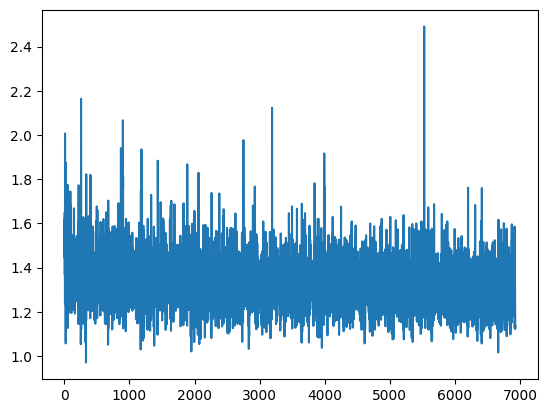

In [35]:
plt.plot(train_losses)

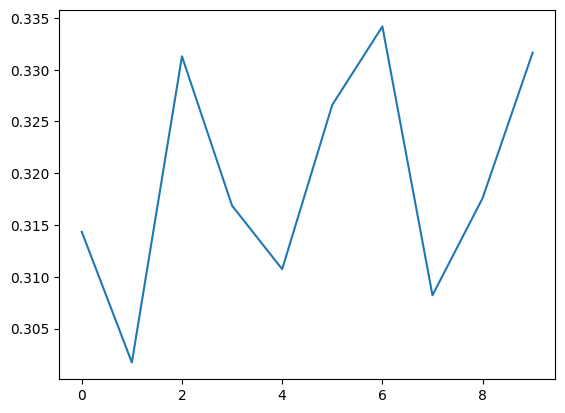

In [36]:
plt.plot(test_accuracy)

In [37]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [38]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 920/2768 (0.3324)
{'acc_detail': tensor([0.0000, 0.7572, 0.0075, 0.3902], device='cuda:0'),
 'acc_unweighted': tensor(0.2887, device='cuda:0'),
 'acc_weighted': tensor(0.3324, device='cuda:0'),
 'f1s': tensor(0.2104, device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.4421, 0.0148, 0.3847], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.3122, 0.4000, 0.3793], device='cuda:0'),
 'recall_detail': tensor([0.0000, 0.7572, 0.0075, 0.3902], device='cuda:0'),
 'rocauc': tensor([0.6475, 0.5896, 0.7239, 0.6114], device='cuda:0'),
 'uar': tensor(0.2887, device='cuda:0'),
 'wap': tensor(0.2759, device='cuda:0')}


tensor([[  0, 379,   1, 262],
        [  0, 605,   2, 192],
        [  0, 471,   4,  55],
        [  0, 483,   3, 311]], device='cuda:0')

In [39]:
model_path = '../models_msp4/msp4_m18_10epochs.pt' 
torch.save(model.state_dict(), model_path)

(array([ 1.,  1.,  2.,  0.,  0.,  0.,  1.,  2.,  2.,  4.,  4.,  8.,  5.,
        14., 12., 20., 22., 25., 22., 35., 39., 62., 70., 66., 85., 47.,
        23., 17., 16., 16., 12.,  2.,  3.,  2.,  2.,  1.,  0.,  0.,  0.,
         2.]),
 array([-0.01284625, -0.01227764, -0.01170903, -0.01114041, -0.0105718 ,
        -0.01000319, -0.00943457, -0.00886596, -0.00829735, -0.00772874,
        -0.00716012, -0.00659151, -0.0060229 , -0.00545428, -0.00488567,
        -0.00431706, -0.00374845, -0.00317983, -0.00261122, -0.00204261,
        -0.00147399, -0.00090538, -0.00033677,  0.00023184,  0.00080046,
         0.00136907,  0.00193768,  0.0025063 ,  0.00307491,  0.00364352,
         0.00421213,  0.00478075,  0.00534936,  0.00591797,  0.00648659,
         0.0070552 ,  0.00762381,  0.00819242,  0.00876104,  0.00932965,
         0.00989826]),
 <BarContainer object of 40 artists>)

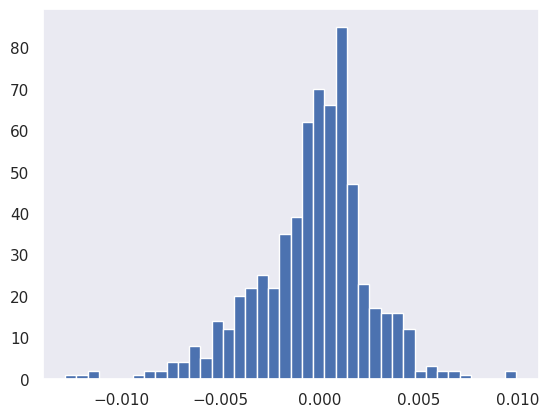

In [40]:
from IConNet.visualizer import visualize_model

layer = model.fe_blocks.blocks[0].block.layer

named_params = [p for p in layer.named_parameters()]
window_params = named_params[2][1].grad.detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

Time domain: Filters' shapes vary by frequency bins


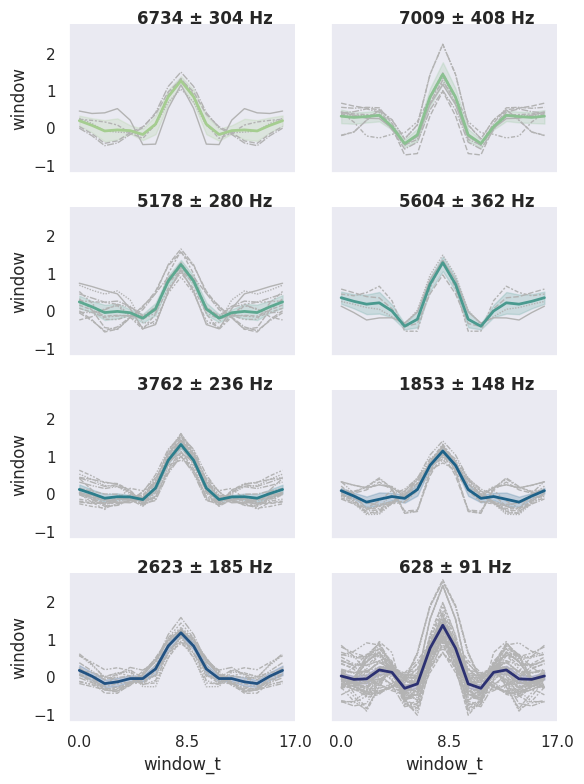

In [41]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


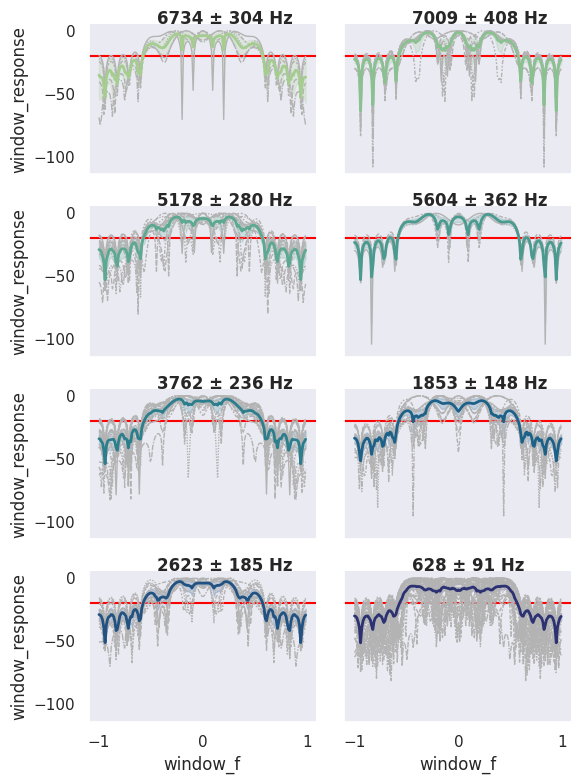

In [42]:
filtviz.visualize_filters(filter_domain='freq')

In [43]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_msp4/msp4_m18_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                         | 0.0011547344110854503/50 [00:00<4:57:15, 356.72s/it]

Train Epoch: 11 [0/11092 (0%)]	Loss: 1.314183
Mem before-during-after: 30938112 3515142656 38382080


  0%|                           | 0.04734411085450344/50 [00:13<4:28:23, 322.37s/it]

Train Epoch: 11 [640/11092 (6%)]	Loss: 1.302631
Mem before-during-after: 38141952 3522808832 38428672


  0%|                           | 0.09353348729792137/50 [00:27<4:29:20, 323.82s/it]

Train Epoch: 11 [1280/11092 (12%)]	Loss: 1.419485
Mem before-during-after: 38141952 3522808832 38428672


  0%|                           | 0.14087759815242493/50 [00:41<3:56:27, 284.56s/it]

Train Epoch: 11 [1920/11092 (17%)]	Loss: 1.112574
Mem before-during-after: 38141952 3522808832 38428672


  0%|                           | 0.18591224018475794/50 [00:54<4:26:26, 320.92s/it]

Train Epoch: 11 [2560/11092 (23%)]	Loss: 1.300691
Mem before-during-after: 38141952 3522808832 38428672


  0%|▏                           | 0.2321016166281764/50 [01:07<4:27:27, 322.46s/it]

Train Epoch: 11 [3200/11092 (29%)]	Loss: 1.323401
Mem before-during-after: 38141952 3522808832 38428672


  1%|▏                           | 0.2782909930715942/50 [01:21<4:27:45, 323.10s/it]

Train Epoch: 11 [3840/11092 (35%)]	Loss: 1.306396
Mem before-during-after: 38141952 3522808832 38428672


  1%|▏                           | 0.3244803695150116/50 [01:34<4:42:16, 340.94s/it]

Train Epoch: 11 [4480/11092 (40%)]	Loss: 1.409274
Mem before-during-after: 38141952 3522808832 38428672


  1%|▏                           | 0.3718244803695144/50 [01:48<3:55:04, 284.20s/it]

Train Epoch: 11 [5120/11092 (46%)]	Loss: 1.405685
Mem before-during-after: 38141952 3522808832 38428672


  1%|▏                           | 0.4168591224018463/50 [02:02<4:28:35, 325.01s/it]

Train Epoch: 11 [5760/11092 (52%)]	Loss: 1.240985
Mem before-during-after: 38141952 3522808832 38428672


  1%|▎                          | 0.46304849884526367/50 [02:15<4:29:05, 325.93s/it]

Train Epoch: 11 [6400/11092 (58%)]	Loss: 1.336967
Mem before-during-after: 38141952 3522808832 38428672


  1%|▎                           | 0.5092378752886815/50 [02:29<4:32:33, 330.44s/it]

Train Epoch: 11 [7040/11092 (63%)]	Loss: 1.299754
Mem before-during-after: 38141952 3522808832 38428672


  1%|▎                           | 0.5554272517321011/50 [02:43<4:26:36, 323.52s/it]

Train Epoch: 11 [7680/11092 (69%)]	Loss: 1.406864
Mem before-during-after: 38141952 3522808832 38428672


  1%|▎                           | 0.6027713625866061/50 [02:56<3:52:35, 282.51s/it]

Train Epoch: 11 [8320/11092 (75%)]	Loss: 1.124368
Mem before-during-after: 38141952 3522808832 38428672


  1%|▎                           | 0.6478060046189402/50 [03:10<4:25:35, 322.89s/it]

Train Epoch: 11 [8960/11092 (81%)]	Loss: 1.046493
Mem before-during-after: 38141952 3522808832 38428672


  1%|▍                           | 0.6939953810623598/50 [03:24<4:36:04, 335.96s/it]

Train Epoch: 11 [9600/11092 (87%)]	Loss: 1.286356
Mem before-during-after: 38141952 3522808832 38428672


  1%|▍                           | 0.7401847575057794/50 [03:37<4:27:41, 326.07s/it]

Train Epoch: 11 [10240/11092 (92%)]	Loss: 1.255296
Mem before-during-after: 38141952 3522808832 38428672


  2%|▍                            | 0.786374133949199/50 [03:51<4:21:45, 319.13s/it]

Train Epoch: 11 [10880/11092 (98%)]	Loss: 1.278247
Mem before-during-after: 38141952 3522808832 38428672


  2%|▌                           | 1.0000000000000144/50 [04:31<2:31:09, 185.10s/it]


Test Epoch: 11	Accuracy: 1009/2768 (36%)

saved model: ../models_msp4/msp4_m18_best_11epoch.pt


  2%|▌                           | 1.0011547344110998/50 [04:31<2:57:29, 217.34s/it]

Train Epoch: 12 [0/11092 (0%)]	Loss: 1.228912
Mem before-during-after: 38137856 3522159616 37987840


  2%|▌                            | 1.047344110854515/50 [04:45<4:24:11, 323.82s/it]

Train Epoch: 12 [640/11092 (6%)]	Loss: 1.443381
Mem before-during-after: 38128128 3522839552 38128128


  2%|▋                             | 1.09353348729793/50 [04:59<4:28:57, 329.97s/it]

Train Epoch: 12 [1280/11092 (12%)]	Loss: 1.231042
Mem before-during-after: 38128128 3522839552 38128128


  2%|▋                           | 1.1397228637413452/50 [05:13<4:21:22, 320.97s/it]

Train Epoch: 12 [1920/11092 (17%)]	Loss: 1.170170
Mem before-during-after: 38128128 3522839552 38128128


  2%|▋                           | 1.1859122401847604/50 [05:26<4:23:18, 323.64s/it]

Train Epoch: 12 [2560/11092 (23%)]	Loss: 1.267684
Mem before-during-after: 38128128 3522839552 38128128


  2%|▋                           | 1.2321016166281755/50 [05:40<4:26:04, 327.36s/it]

Train Epoch: 12 [3200/11092 (29%)]	Loss: 1.313188
Mem before-during-after: 38128128 3522839552 38128128


  3%|▋                           | 1.2782909930715907/50 [05:53<4:26:07, 327.72s/it]

Train Epoch: 12 [3840/11092 (35%)]	Loss: 1.290482
Mem before-during-after: 38128128 3522839552 38128128


  3%|▋                           | 1.3244803695150058/50 [06:07<4:48:17, 355.37s/it]

Train Epoch: 12 [4480/11092 (40%)]	Loss: 1.253454
Mem before-during-after: 38128128 3522839552 38128128


  3%|▊                            | 1.370669745958421/50 [06:21<5:08:16, 380.35s/it]

Train Epoch: 12 [5120/11092 (46%)]	Loss: 1.384818
Mem before-during-after: 38128128 3522839552 38128128


  3%|▊                            | 1.416859122401836/50 [06:35<4:29:02, 332.27s/it]

Train Epoch: 12 [5760/11092 (52%)]	Loss: 1.128034
Mem before-during-after: 38128128 3522839552 38128128


  3%|▊                           | 1.4630484988452512/50 [06:49<4:18:30, 319.57s/it]

Train Epoch: 12 [6400/11092 (58%)]	Loss: 1.347975
Mem before-during-after: 38128128 3522839552 38128128


  3%|▊                           | 1.5092378752886664/50 [07:02<4:22:55, 325.33s/it]

Train Epoch: 12 [7040/11092 (63%)]	Loss: 1.119032
Mem before-during-after: 38128128 3522839552 38128128


  3%|▊                           | 1.5554272517320815/50 [07:16<4:22:38, 325.30s/it]

Train Epoch: 12 [7680/11092 (69%)]	Loss: 1.302872
Mem before-during-after: 38128128 3522839552 38128128


  3%|▉                           | 1.6016166281754967/50 [07:30<4:19:03, 321.16s/it]

Train Epoch: 12 [8320/11092 (75%)]	Loss: 1.341464
Mem before-during-after: 38128128 3522839552 38128128


  3%|▉                           | 1.6478060046189118/50 [07:43<4:19:34, 322.11s/it]

Train Epoch: 12 [8960/11092 (81%)]	Loss: 1.292059
Mem before-during-after: 38128128 3522839552 38128128


  3%|▉                            | 1.693995381062327/50 [07:56<4:19:48, 322.71s/it]

Train Epoch: 12 [9600/11092 (87%)]	Loss: 1.531180
Mem before-during-after: 38128128 3522839552 38128128


  3%|█                            | 1.740184757505742/50 [08:10<4:22:34, 326.46s/it]

Train Epoch: 12 [10240/11092 (92%)]	Loss: 1.232448
Mem before-during-after: 38128128 3522839552 38128128


  4%|█                           | 1.7863741339491572/50 [08:24<4:29:50, 335.81s/it]

Train Epoch: 12 [10880/11092 (98%)]	Loss: 1.183763
Mem before-during-after: 38128128 3522839552 38128128


  4%|█                           | 1.9999999999999523/50 [09:04<2:26:01, 182.53s/it]


Test Epoch: 12	Accuracy: 977/2768 (35%)



  4%|█▏                           | 2.001154734411038/50 [09:05<2:51:08, 213.94s/it]

Train Epoch: 13 [0/11092 (0%)]	Loss: 1.251793
Mem before-during-after: 38124032 3522145792 38128128


  4%|█▏                           | 2.047344110854453/50 [09:19<4:37:21, 347.03s/it]

Train Epoch: 13 [640/11092 (6%)]	Loss: 1.381663
Mem before-during-after: 38128128 3522287104 38128128


  4%|█▏                           | 2.093533487297868/50 [09:33<4:34:12, 343.42s/it]

Train Epoch: 13 [1280/11092 (12%)]	Loss: 1.266493
Mem before-during-after: 38128128 3522287104 38128128


  4%|█▏                          | 2.1397228637412833/50 [09:47<4:25:47, 333.22s/it]

Train Epoch: 13 [1920/11092 (17%)]	Loss: 1.419436
Mem before-during-after: 38128128 3522287104 38128128


  4%|█▏                          | 2.1859122401846984/50 [10:01<4:15:34, 320.72s/it]

Train Epoch: 13 [2560/11092 (23%)]	Loss: 1.320699
Mem before-during-after: 38128128 3522287104 38128128


  4%|█▏                          | 2.2321016166281136/50 [10:14<4:13:56, 318.98s/it]

Train Epoch: 13 [3200/11092 (29%)]	Loss: 1.284618
Mem before-during-after: 38128128 3522287104 38128128


  5%|█▎                          | 2.2782909930715287/50 [10:28<4:14:37, 320.14s/it]

Train Epoch: 13 [3840/11092 (35%)]	Loss: 1.212168
Mem before-during-after: 38128128 3522287104 38128128


  5%|█▎                           | 2.324480369514944/50 [10:41<4:15:41, 321.79s/it]

Train Epoch: 13 [4480/11092 (40%)]	Loss: 1.175244
Mem before-during-after: 38128128 3522287104 38128128


  5%|█▎                           | 2.370669745958359/50 [10:55<4:14:53, 321.10s/it]

Train Epoch: 13 [5120/11092 (46%)]	Loss: 1.300339
Mem before-during-after: 38128128 3522287104 38128128


  5%|█▍                           | 2.416859122401774/50 [11:08<4:20:47, 328.84s/it]

Train Epoch: 13 [5760/11092 (52%)]	Loss: 1.166583
Mem before-during-after: 38128128 3522287104 38128128


  5%|█▍                          | 2.4630484988451893/50 [11:21<4:10:45, 316.50s/it]

Train Epoch: 13 [6400/11092 (58%)]	Loss: 1.314769
Mem before-during-after: 38128128 3522287104 38128128


  5%|█▍                          | 2.5092378752886044/50 [11:35<4:18:26, 326.52s/it]

Train Epoch: 13 [7040/11092 (63%)]	Loss: 1.180504
Mem before-during-after: 38128128 3522287104 38128128


  5%|█▍                          | 2.5554272517320196/50 [11:48<4:18:08, 326.46s/it]

Train Epoch: 13 [7680/11092 (69%)]	Loss: 1.163622
Mem before-during-after: 38128128 3522287104 38128128


  5%|█▍                          | 2.6016166281754347/50 [12:01<4:10:50, 317.53s/it]

Train Epoch: 13 [8320/11092 (75%)]	Loss: 1.314135
Mem before-during-after: 38128128 3522287104 38128128


  5%|█▌                            | 2.64780600461885/50 [12:15<4:11:28, 318.64s/it]

Train Epoch: 13 [8960/11092 (81%)]	Loss: 1.385402
Mem before-during-after: 38128128 3522287104 38128128


  5%|█▌                           | 2.693995381062265/50 [12:28<4:11:31, 319.02s/it]

Train Epoch: 13 [9600/11092 (87%)]	Loss: 1.313957
Mem before-during-after: 38128128 3522287104 38128128


  5%|█▋                            | 2.74018475750568/50 [12:41<4:10:42, 318.29s/it]

Train Epoch: 13 [10240/11092 (92%)]	Loss: 1.190880
Mem before-during-after: 38128128 3522287104 38128128


  6%|█▌                          | 2.7863741339490953/50 [12:54<4:10:16, 318.06s/it]

Train Epoch: 13 [10880/11092 (98%)]	Loss: 1.162421
Mem before-during-after: 38128128 3522287104 38128128


  6%|█▋                          | 2.9999999999998903/50 [13:34<2:19:36, 178.22s/it]


Test Epoch: 13	Accuracy: 989/2768 (36%)



  6%|█▋                          | 3.0011547344109757/50 [13:34<2:47:59, 214.46s/it]

Train Epoch: 14 [0/11092 (0%)]	Loss: 1.366841
Mem before-during-after: 38124032 3522145792 38128128


  6%|█▊                           | 3.047344110854391/50 [13:47<4:08:52, 318.03s/it]

Train Epoch: 14 [640/11092 (6%)]	Loss: 1.178712
Mem before-during-after: 38128128 3522287104 38128128


  6%|█▊                           | 3.093533487297806/50 [14:00<4:06:13, 314.96s/it]

Train Epoch: 14 [1280/11092 (12%)]	Loss: 1.193173
Mem before-during-after: 38128128 3522287104 38128128


  6%|█▊                          | 3.1408775981523065/50 [14:14<3:35:18, 275.69s/it]

Train Epoch: 14 [1920/11092 (17%)]	Loss: 1.329635
Mem before-during-after: 38128128 3522287104 38128128


  6%|█▊                          | 3.1859122401846363/50 [14:28<4:08:35, 318.61s/it]

Train Epoch: 14 [2560/11092 (23%)]	Loss: 1.202517
Mem before-during-after: 38128128 3522287104 38128128


  6%|█▊                          | 3.2321016166280514/50 [14:41<4:11:30, 322.67s/it]

Train Epoch: 14 [3200/11092 (29%)]	Loss: 1.129217
Mem before-during-after: 38128128 3522287104 38128128


  7%|█▊                          | 3.2782909930714665/50 [14:55<4:24:30, 339.69s/it]

Train Epoch: 14 [3840/11092 (35%)]	Loss: 1.370046
Mem before-during-after: 38128128 3522287104 38128128


  7%|█▊                          | 3.3244803695148817/50 [15:09<4:10:52, 322.50s/it]

Train Epoch: 14 [4480/11092 (40%)]	Loss: 1.145421
Mem before-during-after: 38128128 3522287104 38128128


  7%|█▉                           | 3.370669745958297/50 [15:22<4:06:53, 317.70s/it]

Train Epoch: 14 [5120/11092 (46%)]	Loss: 1.069369
Mem before-during-after: 38128128 3522287104 38128128


  7%|█▉                           | 3.416859122401712/50 [15:35<4:04:44, 315.23s/it]

Train Epoch: 14 [5760/11092 (52%)]	Loss: 1.153939
Mem before-during-after: 38128128 3522287104 38128128


  7%|██                           | 3.463048498845127/50 [15:48<4:05:23, 316.38s/it]

Train Epoch: 14 [6400/11092 (58%)]	Loss: 1.205132
Mem before-during-after: 38128128 3522287104 38128128


  7%|█▉                          | 3.5092378752885423/50 [16:01<4:04:16, 315.25s/it]

Train Epoch: 14 [7040/11092 (63%)]	Loss: 1.458732
Mem before-during-after: 38128128 3522287104 38128128


  7%|█▉                          | 3.5554272517319574/50 [16:14<4:07:11, 319.35s/it]

Train Epoch: 14 [7680/11092 (69%)]	Loss: 1.187816
Mem before-during-after: 38128128 3522287104 38128128


  7%|██                          | 3.6016166281753725/50 [16:28<4:04:37, 316.33s/it]

Train Epoch: 14 [8320/11092 (75%)]	Loss: 1.097516
Mem before-during-after: 38128128 3522287104 38128128


  7%|██                          | 3.6478060046187877/50 [16:41<4:07:07, 319.88s/it]

Train Epoch: 14 [8960/11092 (81%)]	Loss: 1.195671
Mem before-during-after: 38128128 3522287104 38128128


  7%|██▏                          | 3.693995381062203/50 [16:54<4:09:03, 322.70s/it]

Train Epoch: 14 [9600/11092 (87%)]	Loss: 1.292872
Mem before-during-after: 38128128 3522287104 38128128


  7%|██▏                          | 3.740184757505618/50 [17:08<4:05:57, 319.01s/it]

Train Epoch: 14 [10240/11092 (92%)]	Loss: 1.258102
Mem before-during-after: 38128128 3522287104 38128128


  8%|██                          | 3.7875288683601185/50 [17:21<3:34:40, 278.73s/it]

Train Epoch: 14 [10880/11092 (98%)]	Loss: 1.128279
Mem before-during-after: 38128128 3522287104 38128128


  8%|██▎                          | 3.999999999999828/50 [18:01<2:24:07, 187.99s/it]


Test Epoch: 14	Accuracy: 1018/2768 (37%)

saved model: ../models_msp4/msp4_m18_best_14epoch.pt


  8%|██▎                          | 4.002309468821999/50 [18:02<2:38:57, 207.35s/it]

Train Epoch: 15 [0/11092 (0%)]	Loss: 1.214176
Mem before-during-after: 38124032 3522145792 38128128


  8%|██▎                          | 4.047344110854329/50 [18:15<4:04:24, 319.12s/it]

Train Epoch: 15 [640/11092 (6%)]	Loss: 1.382463
Mem before-during-after: 38128128 3522287104 38128128


  8%|██▎                          | 4.093533487297744/50 [18:29<4:04:45, 319.90s/it]

Train Epoch: 15 [1280/11092 (12%)]	Loss: 1.368103
Mem before-during-after: 38128128 3522287104 38128128


  8%|██▍                          | 4.139722863741159/50 [18:42<4:05:32, 321.24s/it]

Train Epoch: 15 [1920/11092 (17%)]	Loss: 1.361445
Mem before-during-after: 38128128 3522287104 38128128


  8%|██▎                         | 4.1859122401845745/50 [18:55<4:19:54, 340.39s/it]

Train Epoch: 15 [2560/11092 (23%)]	Loss: 1.121717
Mem before-during-after: 38128128 3522287104 38128128


  8%|██▌                           | 4.23210161662799/50 [19:09<4:00:46, 315.65s/it]

Train Epoch: 15 [3200/11092 (29%)]	Loss: 1.245022
Mem before-during-after: 38128128 3522287104 38128128


  9%|██▍                          | 4.278290993071405/50 [19:22<4:01:38, 317.11s/it]

Train Epoch: 15 [3840/11092 (35%)]	Loss: 1.043920
Mem before-during-after: 38128128 3522287104 38128128


  9%|██▌                          | 4.325635103925905/50 [19:35<3:31:57, 278.43s/it]

Train Epoch: 15 [4480/11092 (40%)]	Loss: 1.284069
Mem before-during-after: 38128128 3522287104 38128128


  9%|██▌                          | 4.370669745958235/50 [19:48<4:03:17, 319.91s/it]

Train Epoch: 15 [5120/11092 (46%)]	Loss: 1.326060
Mem before-during-after: 38128128 3522287104 38128128


  9%|██▋                           | 4.41685912240165/50 [20:01<4:02:09, 318.75s/it]

Train Epoch: 15 [5760/11092 (52%)]	Loss: 1.369429
Mem before-during-after: 38128128 3522287104 38128128


  9%|██▌                          | 4.463048498845065/50 [20:14<4:01:22, 318.04s/it]

Train Epoch: 15 [6400/11092 (58%)]	Loss: 1.003104
Mem before-during-after: 38128128 3522287104 38128128


  9%|██▌                         | 4.5092378752884805/50 [20:28<4:04:11, 322.07s/it]

Train Epoch: 15 [7040/11092 (63%)]	Loss: 1.276496
Mem before-during-after: 38128128 3522287104 38128128


  9%|██▋                          | 4.555427251731896/50 [20:41<4:03:33, 321.56s/it]

Train Epoch: 15 [7680/11092 (69%)]	Loss: 1.204846
Mem before-during-after: 38128128 3522287104 38128128


  9%|██▋                          | 4.601616628175311/50 [20:54<3:59:50, 316.97s/it]

Train Epoch: 15 [8320/11092 (75%)]	Loss: 1.187907
Mem before-during-after: 38128128 3522287104 38128128


  9%|██▋                          | 4.647806004618726/50 [21:08<3:59:19, 316.63s/it]

Train Epoch: 15 [8960/11092 (81%)]	Loss: 1.312973
Mem before-during-after: 38128128 3522287104 38128128


  9%|██▋                          | 4.693995381062141/50 [21:21<4:00:37, 318.67s/it]

Train Epoch: 15 [9600/11092 (87%)]	Loss: 1.335624
Mem before-during-after: 38128128 3522287104 38128128


  9%|██▋                          | 4.740184757505556/50 [21:34<3:58:26, 316.10s/it]

Train Epoch: 15 [10240/11092 (92%)]	Loss: 1.323789
Mem before-during-after: 38128128 3522287104 38128128


 10%|██▊                          | 4.786374133948971/50 [21:47<3:58:59, 317.15s/it]

Train Epoch: 15 [10880/11092 (98%)]	Loss: 1.097183
Mem before-during-after: 38128128 3522287104 38128128


 10%|██▉                          | 4.999999999999766/50 [22:26<2:16:38, 182.20s/it]


Test Epoch: 15	Accuracy: 997/2768 (36%)



 10%|██▉                          | 5.001154734410852/50 [22:27<2:44:37, 219.51s/it]

Train Epoch: 16 [0/11092 (0%)]	Loss: 1.376172
Mem before-during-after: 38124032 3522145792 38128128


 10%|██▉                          | 5.047344110854267/50 [22:40<3:57:01, 316.36s/it]

Train Epoch: 16 [640/11092 (6%)]	Loss: 1.318616
Mem before-during-after: 38128128 3522287104 38128128


 10%|██▉                          | 5.093533487297682/50 [22:53<3:59:35, 320.11s/it]

Train Epoch: 16 [1280/11092 (12%)]	Loss: 1.263898
Mem before-during-after: 38128128 3522287104 38128128


 10%|██▉                          | 5.139722863741097/50 [23:06<3:55:52, 315.47s/it]

Train Epoch: 16 [1920/11092 (17%)]	Loss: 1.343586
Mem before-during-after: 38128128 3522287104 38128128


 10%|███                          | 5.187066974595598/50 [23:20<3:28:41, 279.42s/it]

Train Epoch: 16 [2560/11092 (23%)]	Loss: 1.237796
Mem before-during-after: 38128128 3522287104 38128128


 10%|██▉                         | 5.2321016166279275/50 [23:33<3:58:34, 319.75s/it]

Train Epoch: 16 [3200/11092 (29%)]	Loss: 1.190700
Mem before-during-after: 38128128 3522287104 38128128


 11%|███                          | 5.278290993071343/50 [23:46<3:59:40, 321.56s/it]

Train Epoch: 16 [3840/11092 (35%)]	Loss: 1.270074
Mem before-during-after: 38128128 3522287104 38128128


 11%|███                          | 5.324480369514758/50 [23:59<3:56:58, 318.26s/it]

Train Epoch: 16 [4480/11092 (40%)]	Loss: 1.201155
Mem before-during-after: 38128128 3522287104 38128128


 11%|███                          | 5.370669745958173/50 [24:12<3:57:06, 318.76s/it]

Train Epoch: 16 [5120/11092 (46%)]	Loss: 1.209553
Mem before-during-after: 38128128 3522287104 38128128


 11%|███▏                         | 5.416859122401588/50 [24:26<3:57:33, 319.70s/it]

Train Epoch: 16 [5760/11092 (52%)]	Loss: 1.321872
Mem before-during-after: 38128128 3522287104 38128128


 11%|███▏                         | 5.463048498845003/50 [24:39<4:03:35, 328.16s/it]

Train Epoch: 16 [6400/11092 (58%)]	Loss: 1.401424
Mem before-during-after: 38128128 3522287104 38128128


 11%|███▏                         | 5.509237875288418/50 [24:52<4:02:58, 327.68s/it]

Train Epoch: 16 [7040/11092 (63%)]	Loss: 1.288783
Mem before-during-after: 38128128 3522287104 38128128


 11%|███                         | 5.5554272517318335/50 [25:06<4:03:58, 329.37s/it]

Train Epoch: 16 [7680/11092 (69%)]	Loss: 1.408176
Mem before-during-after: 38128128 3522287104 38128128


 11%|███▏                         | 5.601616628175249/50 [25:20<3:54:10, 316.46s/it]

Train Epoch: 16 [8320/11092 (75%)]	Loss: 1.213574
Mem before-during-after: 38128128 3522287104 38128128


 11%|███▎                         | 5.647806004618664/50 [25:33<3:57:37, 321.45s/it]

Train Epoch: 16 [8960/11092 (81%)]	Loss: 1.423257
Mem before-during-after: 38128128 3522287104 38128128


 11%|███▎                         | 5.695150115473164/50 [25:47<3:21:21, 272.69s/it]

Train Epoch: 16 [9600/11092 (87%)]	Loss: 1.200457
Mem before-during-after: 38128128 3522287104 38128128


 11%|███▎                         | 5.740184757505494/50 [26:00<3:56:02, 319.98s/it]

Train Epoch: 16 [10240/11092 (92%)]	Loss: 1.280221
Mem before-during-after: 38128128 3522287104 38128128


 12%|███▎                         | 5.786374133948909/50 [26:13<3:59:17, 324.72s/it]

Train Epoch: 16 [10880/11092 (98%)]	Loss: 1.359399
Mem before-during-after: 38128128 3522287104 38128128


 12%|███▍                         | 5.999999999999704/50 [26:54<2:19:16, 189.92s/it]


Test Epoch: 16	Accuracy: 1009/2768 (36%)



 12%|███▌                          | 6.00115473441079/50 [26:54<2:41:47, 220.64s/it]

Train Epoch: 17 [0/11092 (0%)]	Loss: 1.266021
Mem before-during-after: 38124032 3522145792 38128128


 12%|███▌                         | 6.047344110854205/50 [27:08<3:50:55, 315.23s/it]

Train Epoch: 17 [640/11092 (6%)]	Loss: 1.117634
Mem before-during-after: 38128128 3522287104 38128128


 12%|███▋                          | 6.09353348729762/50 [27:21<4:06:16, 336.54s/it]

Train Epoch: 17 [1280/11092 (12%)]	Loss: 1.309420
Mem before-during-after: 38128128 3522287104 38128128


 12%|███▌                         | 6.139722863741035/50 [27:34<3:53:10, 318.99s/it]

Train Epoch: 17 [1920/11092 (17%)]	Loss: 1.174398
Mem before-during-after: 38128128 3522287104 38128128


 12%|███▋                          | 6.18591224018445/50 [27:48<4:00:58, 330.00s/it]

Train Epoch: 17 [2560/11092 (23%)]	Loss: 1.224718
Mem before-during-after: 38128128 3522287104 38128128


 12%|███▌                         | 6.232101616627865/50 [28:01<3:54:57, 322.11s/it]

Train Epoch: 17 [3200/11092 (29%)]	Loss: 1.287678
Mem before-during-after: 38128128 3522287104 38128128


 13%|███▌                        | 6.2782909930712805/50 [28:14<3:51:16, 317.38s/it]

Train Epoch: 17 [3840/11092 (35%)]	Loss: 1.230741
Mem before-during-after: 38128128 3522287104 38128128


 13%|███▋                         | 6.324480369514696/50 [28:27<3:50:23, 316.51s/it]

Train Epoch: 17 [4480/11092 (40%)]	Loss: 1.087841
Mem before-during-after: 38128128 3522287104 38128128


 13%|███▋                         | 6.370669745958111/50 [28:40<3:52:49, 320.20s/it]

Train Epoch: 17 [5120/11092 (46%)]	Loss: 1.380221
Mem before-during-after: 38128128 3522287104 38128128


 13%|███▋                         | 6.416859122401526/50 [28:54<3:53:04, 320.87s/it]

Train Epoch: 17 [5760/11092 (52%)]	Loss: 1.178903
Mem before-during-after: 38128128 3522287104 38128128


 13%|███▋                         | 6.464203233256026/50 [29:07<3:19:16, 274.62s/it]

Train Epoch: 17 [6400/11092 (58%)]	Loss: 1.176677
Mem before-during-after: 38128128 3522287104 38128128


 13%|███▊                         | 6.509237875288356/50 [29:20<3:49:19, 316.38s/it]

Train Epoch: 17 [7040/11092 (63%)]	Loss: 1.262835
Mem before-during-after: 38128128 3522287104 38128128


 13%|███▊                         | 6.555427251731771/50 [29:34<3:49:16, 316.65s/it]

Train Epoch: 17 [7680/11092 (69%)]	Loss: 1.364168
Mem before-during-after: 38128128 3522287104 38128128


 13%|███▋                        | 6.6016166281751865/50 [29:47<3:50:05, 318.12s/it]

Train Epoch: 17 [8320/11092 (75%)]	Loss: 1.248885
Mem before-during-after: 38128128 3522287104 38128128


 13%|███▊                         | 6.647806004618602/50 [30:00<3:48:23, 316.09s/it]

Train Epoch: 17 [8960/11092 (81%)]	Loss: 1.228056
Mem before-during-after: 38128128 3522287104 38128128


 13%|███▉                         | 6.693995381062017/50 [30:13<3:49:25, 317.87s/it]

Train Epoch: 17 [9600/11092 (87%)]	Loss: 1.129550
Mem before-during-after: 38128128 3522287104 38128128


 13%|███▉                         | 6.740184757505432/50 [30:26<3:48:20, 316.71s/it]

Train Epoch: 17 [10240/11092 (92%)]	Loss: 1.241242
Mem before-during-after: 38128128 3522287104 38128128


 14%|███▉                         | 6.786374133948847/50 [30:39<3:48:53, 317.81s/it]

Train Epoch: 17 [10880/11092 (98%)]	Loss: 1.184832
Mem before-during-after: 38128128 3522287104 38128128


 14%|████                         | 6.999999999999642/50 [31:20<2:16:41, 190.73s/it]


Test Epoch: 17	Accuracy: 1021/2768 (37%)

saved model: ../models_msp4/msp4_m18_best_17epoch.pt


 14%|████                         | 7.001154734410727/50 [31:20<2:41:27, 225.29s/it]

Train Epoch: 18 [0/11092 (0%)]	Loss: 1.236772
Mem before-during-after: 38124032 3522145792 38128128


 14%|████                         | 7.047344110854143/50 [31:33<3:47:13, 317.42s/it]

Train Epoch: 18 [640/11092 (6%)]	Loss: 1.105207
Mem before-during-after: 38128128 3522287104 38128128


 14%|████                         | 7.093533487297558/50 [31:47<4:01:24, 337.58s/it]

Train Epoch: 18 [1280/11092 (12%)]	Loss: 1.273023
Mem before-during-after: 38128128 3522287104 38128128


 14%|████▏                        | 7.139722863740973/50 [32:01<3:49:22, 321.10s/it]

Train Epoch: 18 [1920/11092 (17%)]	Loss: 1.393778
Mem before-during-after: 38128128 3522287104 38128128


 14%|████▏                        | 7.185912240184388/50 [32:14<3:48:06, 319.68s/it]

Train Epoch: 18 [2560/11092 (23%)]	Loss: 1.278967
Mem before-during-after: 38128128 3522287104 38128128


 14%|████▏                        | 7.232101616627803/50 [32:27<3:45:20, 316.14s/it]

Train Epoch: 18 [3200/11092 (29%)]	Loss: 1.257545
Mem before-during-after: 38128128 3522287104 38128128


 15%|████▏                        | 7.278290993071218/50 [32:41<3:45:09, 316.21s/it]

Train Epoch: 18 [3840/11092 (35%)]	Loss: 1.232975
Mem before-during-after: 38128128 3522287104 38128128


 15%|████▏                        | 7.324480369514633/50 [32:54<3:47:56, 320.48s/it]

Train Epoch: 18 [4480/11092 (40%)]	Loss: 1.217714
Mem before-during-after: 38128128 3522287104 38128128


 15%|████▎                        | 7.370669745958049/50 [33:07<3:44:41, 316.25s/it]

Train Epoch: 18 [5120/11092 (46%)]	Loss: 1.322677
Mem before-during-after: 38128128 3522287104 38128128


 15%|████▎                        | 7.418013856812549/50 [33:20<3:14:24, 273.93s/it]

Train Epoch: 18 [5760/11092 (52%)]	Loss: 1.207320
Mem before-during-after: 38128128 3522287104 38128128


 15%|████▎                        | 7.463048498844879/50 [33:33<3:49:25, 323.61s/it]

Train Epoch: 18 [6400/11092 (58%)]	Loss: 1.266342
Mem before-during-after: 38128128 3522287104 38128128


 15%|████▎                        | 7.509237875288294/50 [33:46<3:46:19, 319.58s/it]

Train Epoch: 18 [7040/11092 (63%)]	Loss: 1.271179
Mem before-during-after: 38128128 3522287104 38128128


 15%|████▍                        | 7.555427251731709/50 [34:00<3:48:11, 322.58s/it]

Train Epoch: 18 [7680/11092 (69%)]	Loss: 1.221102
Mem before-during-after: 38128128 3522287104 38128128


 15%|████▍                        | 7.601616628175124/50 [34:13<3:45:50, 319.60s/it]

Train Epoch: 18 [8320/11092 (75%)]	Loss: 1.421512
Mem before-during-after: 38128128 3522287104 38128128


 15%|████▍                        | 7.647806004618539/50 [34:26<3:49:27, 325.07s/it]

Train Epoch: 18 [8960/11092 (81%)]	Loss: 0.962954
Mem before-during-after: 38128128 3522287104 38128128


 15%|████▍                        | 7.693995381061955/50 [34:39<3:44:36, 318.55s/it]

Train Epoch: 18 [9600/11092 (87%)]	Loss: 1.338647
Mem before-during-after: 38128128 3522287104 38128128


 15%|████▋                         | 7.74018475750537/50 [34:53<3:51:19, 328.44s/it]

Train Epoch: 18 [10240/11092 (92%)]	Loss: 1.286166
Mem before-during-after: 38128128 3522287104 38128128


 16%|████▌                        | 7.786374133948785/50 [35:07<3:45:39, 320.75s/it]

Train Epoch: 18 [10880/11092 (98%)]	Loss: 1.337801
Mem before-during-after: 38128128 3522287104 38128128


 16%|████▊                         | 7.99999999999958/50 [35:47<2:04:39, 178.09s/it]


Test Epoch: 18	Accuracy: 1000/2768 (36%)



 16%|████▋                        | 8.002309468821752/50 [35:48<2:20:34, 200.83s/it]

Train Epoch: 19 [0/11092 (0%)]	Loss: 1.145198
Mem before-during-after: 38124032 3522145792 38128128


 16%|████▋                        | 8.047344110854116/50 [36:01<3:42:33, 318.31s/it]

Train Epoch: 19 [640/11092 (6%)]	Loss: 1.144963
Mem before-during-after: 38128128 3522287104 38128128


 16%|████▋                        | 8.093533487297567/50 [36:14<3:43:54, 320.59s/it]

Train Epoch: 19 [1280/11092 (12%)]	Loss: 1.215434
Mem before-during-after: 38128128 3522287104 38128128


 16%|████▋                        | 8.139722863741017/50 [36:28<3:42:33, 319.00s/it]

Train Epoch: 19 [1920/11092 (17%)]	Loss: 1.197879
Mem before-during-after: 38128128 3522287104 38128128


 16%|████▋                        | 8.185912240184468/50 [36:41<3:44:19, 321.89s/it]

Train Epoch: 19 [2560/11092 (23%)]	Loss: 1.208894
Mem before-during-after: 38128128 3522287104 38128128


 16%|████▊                        | 8.232101616627919/50 [36:54<3:42:32, 319.68s/it]

Train Epoch: 19 [3200/11092 (29%)]	Loss: 1.343885
Mem before-during-after: 38128128 3522287104 38128128


 17%|████▉                         | 8.27829099307137/50 [37:07<3:39:44, 316.01s/it]

Train Epoch: 19 [3840/11092 (35%)]	Loss: 1.269867
Mem before-during-after: 38128128 3522287104 38128128


 17%|████▉                         | 8.32448036951482/50 [37:21<3:46:01, 325.41s/it]

Train Epoch: 19 [4480/11092 (40%)]	Loss: 1.364968
Mem before-during-after: 38128128 3522287104 38128128


 17%|█████                         | 8.37066974595827/50 [37:34<3:42:31, 320.73s/it]

Train Epoch: 19 [5120/11092 (46%)]	Loss: 1.393613
Mem before-during-after: 38128128 3522287104 38128128


 17%|████▉                        | 8.416859122401721/50 [37:47<3:45:23, 325.20s/it]

Train Epoch: 19 [5760/11092 (52%)]	Loss: 1.243184
Mem before-during-after: 38128128 3522287104 38128128


 17%|████▉                        | 8.463048498845172/50 [38:00<3:41:28, 319.92s/it]

Train Epoch: 19 [6400/11092 (58%)]	Loss: 1.161237
Mem before-during-after: 38128128 3522287104 38128128


 17%|████▉                        | 8.509237875288623/50 [38:14<3:39:23, 317.25s/it]

Train Epoch: 19 [7040/11092 (63%)]	Loss: 1.110312
Mem before-during-after: 38128128 3522287104 38128128


 17%|████▉                        | 8.555427251732073/50 [38:27<3:38:38, 316.54s/it]

Train Epoch: 19 [7680/11092 (69%)]	Loss: 1.192208
Mem before-during-after: 38128128 3522287104 38128128


 17%|████▉                        | 8.601616628175524/50 [38:40<3:43:23, 323.77s/it]

Train Epoch: 19 [8320/11092 (75%)]	Loss: 1.294798
Mem before-during-after: 38128128 3522287104 38128128


 17%|█████                        | 8.647806004618975/50 [38:53<3:41:19, 321.14s/it]

Train Epoch: 19 [8960/11092 (81%)]	Loss: 1.499743
Mem before-during-after: 38128128 3522287104 38128128


 17%|█████                        | 8.693995381062425/50 [39:07<3:39:38, 319.05s/it]

Train Epoch: 19 [9600/11092 (87%)]	Loss: 1.219468
Mem before-during-after: 38128128 3522287104 38128128


 17%|█████                        | 8.740184757505876/50 [39:20<3:37:13, 315.88s/it]

Train Epoch: 19 [10240/11092 (92%)]	Loss: 1.466143
Mem before-during-after: 38128128 3522287104 38128128


 18%|█████                        | 8.786374133949327/50 [39:33<3:38:11, 317.65s/it]

Train Epoch: 19 [10880/11092 (98%)]	Loss: 1.247776
Mem before-during-after: 38128128 3522287104 38128128


 18%|█████▏                       | 9.000000000000286/50 [40:13<1:59:56, 175.52s/it]


Test Epoch: 19	Accuracy: 1035/2768 (37%)

saved model: ../models_msp4/msp4_m18_best_19epoch.pt


 18%|█████▏                       | 9.001154734411372/50 [40:13<2:30:37, 220.43s/it]

Train Epoch: 20 [0/11092 (0%)]	Loss: 1.275248
Mem before-during-after: 38124032 3522145792 38128128


 18%|█████▏                       | 9.047344110854823/50 [40:26<3:36:41, 317.48s/it]

Train Epoch: 20 [640/11092 (6%)]	Loss: 1.149945
Mem before-during-after: 38128128 3522287104 38128128


 18%|█████▎                       | 9.093533487298274/50 [40:39<3:36:07, 316.99s/it]

Train Epoch: 20 [1280/11092 (12%)]	Loss: 1.236994
Mem before-during-after: 38128128 3522287104 38128128


 18%|█████▎                       | 9.139722863741724/50 [40:53<3:35:07, 315.90s/it]

Train Epoch: 20 [1920/11092 (17%)]	Loss: 1.451779
Mem before-during-after: 38128128 3522287104 38128128


 18%|█████▎                       | 9.185912240185175/50 [41:06<3:34:32, 315.38s/it]

Train Epoch: 20 [2560/11092 (23%)]	Loss: 1.332720
Mem before-during-after: 38128128 3522287104 38128128


 18%|█████▎                       | 9.232101616628626/50 [41:19<3:36:35, 318.77s/it]

Train Epoch: 20 [3200/11092 (29%)]	Loss: 1.170017
Mem before-during-after: 38128128 3522287104 38128128


 19%|█████▍                       | 9.278290993072076/50 [41:32<3:38:25, 321.83s/it]

Train Epoch: 20 [3840/11092 (35%)]	Loss: 1.094740
Mem before-during-after: 38128128 3522287104 38128128


 19%|█████▍                       | 9.324480369515527/50 [41:45<3:35:37, 318.07s/it]

Train Epoch: 20 [4480/11092 (40%)]	Loss: 1.092751
Mem before-during-after: 38128128 3522287104 38128128


 19%|█████▍                       | 9.370669745958978/50 [41:59<3:37:38, 321.40s/it]

Train Epoch: 20 [5120/11092 (46%)]	Loss: 1.297305
Mem before-during-after: 38128128 3522287104 38128128


 19%|█████▍                       | 9.416859122402428/50 [42:12<3:36:00, 319.36s/it]

Train Epoch: 20 [5760/11092 (52%)]	Loss: 1.406274
Mem before-during-after: 38128128 3522287104 38128128


 19%|█████▍                       | 9.463048498845879/50 [42:25<3:33:41, 316.29s/it]

Train Epoch: 20 [6400/11092 (58%)]	Loss: 1.265180
Mem before-during-after: 38128128 3522287104 38128128


 19%|█████▋                        | 9.50923787528933/50 [42:38<3:33:38, 316.57s/it]

Train Epoch: 20 [7040/11092 (63%)]	Loss: 1.220287
Mem before-during-after: 38128128 3522287104 38128128


 19%|█████▋                        | 9.55542725173278/50 [42:51<3:33:27, 316.68s/it]

Train Epoch: 20 [7680/11092 (69%)]	Loss: 1.172545
Mem before-during-after: 38128128 3522287104 38128128


 19%|█████▌                       | 9.601616628176231/50 [43:04<3:38:36, 324.68s/it]

Train Epoch: 20 [8320/11092 (75%)]	Loss: 1.421760
Mem before-during-after: 38128128 3522287104 38128128


 19%|█████▌                       | 9.647806004619682/50 [43:18<3:32:41, 316.26s/it]

Train Epoch: 20 [8960/11092 (81%)]	Loss: 1.217321
Mem before-during-after: 38128128 3522287104 38128128


 19%|█████▌                       | 9.693995381063132/50 [43:31<3:44:23, 334.04s/it]

Train Epoch: 20 [9600/11092 (87%)]	Loss: 1.297809
Mem before-during-after: 38128128 3522287104 38128128


 19%|█████▋                       | 9.740184757506583/50 [43:45<3:36:44, 323.02s/it]

Train Epoch: 20 [10240/11092 (92%)]	Loss: 1.235111
Mem before-during-after: 38128128 3522287104 38128128


 20%|█████▊                        | 9.78752886836112/50 [43:58<3:08:27, 281.19s/it]

Train Epoch: 20 [10880/11092 (98%)]	Loss: 1.445995
Mem before-during-after: 38128128 3522287104 38128128


 20%|█████▌                      | 10.000000000000993/50 [44:38<1:56:38, 174.97s/it]


Test Epoch: 20	Accuracy: 1047/2768 (38%)

saved model: ../models_msp4/msp4_m18_best_20epoch.pt


 20%|█████▊                       | 10.00115473441208/50 [44:38<2:22:10, 213.28s/it]

Train Epoch: 21 [0/11092 (0%)]	Loss: 1.397841
Mem before-during-after: 38124032 3522145792 38128128


 20%|█████▊                       | 10.04734411085553/50 [44:52<3:33:57, 321.31s/it]

Train Epoch: 21 [640/11092 (6%)]	Loss: 1.420394
Mem before-during-after: 38128128 3522287104 38128128


 20%|█████▋                      | 10.054272517322048/50 [44:54<3:16:57, 295.83s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f092c1d2190>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 20%|█████▋                      | 10.055427251733134/50 [44:54<2:58:23, 267.96s/it]


KeyboardInterrupt: 

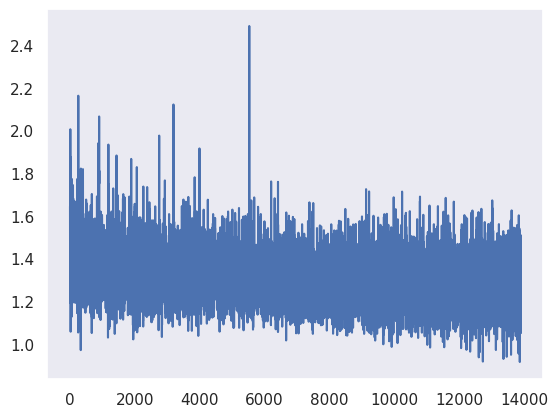

In [44]:
plt.plot(train_losses)

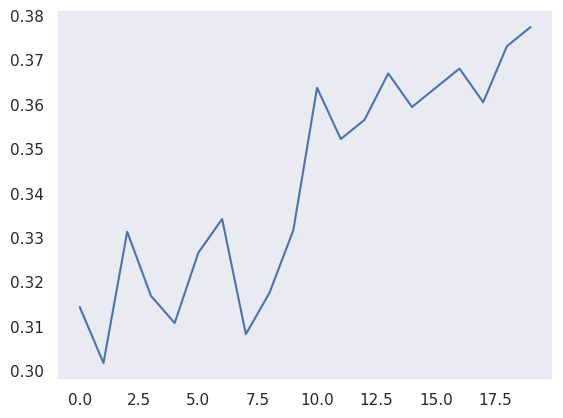

In [45]:
plt.plot(test_accuracy)

In [46]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 1060/2768 (0.3829)
{'acc_detail': tensor([0.2695, 0.5031, 0.2962, 0.4115], device='cuda:0'),
 'acc_unweighted': tensor(0.3701, device='cuda:0'),
 'acc_weighted': tensor(0.3829, device='cuda:0'),
 'f1s': tensor(0.3713, device='cuda:0'),
 'f1s_detail': tensor([0.3067, 0.4386, 0.3470, 0.3928], device='cuda:0'),
 'precision_detail': tensor([0.3560, 0.3888, 0.4187, 0.3757], device='cuda:0'),
 'recall_detail': tensor([0.2695, 0.5031, 0.2962, 0.4115], device='cuda:0'),
 'rocauc': tensor([0.6716, 0.6227, 0.7337, 0.6296], device='cuda:0'),
 'uar': tensor(0.3701, device='cuda:0'),
 'wap': tensor(0.3831, device='cuda:0')}


tensor([[173, 166,  50, 253],
        [ 95, 402,  93, 209],
        [ 55, 235, 157,  83],
        [163, 231,  75, 328]], device='cuda:0')

In [47]:
checkpoint_path = '../models_msp4/msp4_m18_20epoch.ckpt'
torch.save({
    'epoch': 20,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [48]:
n_epoch = 10
n_epoch2 = 10
n_epoch3 = 80

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                         | 0.0011547344110854503/80 [00:00<8:01:33, 361.17s/it]

Train Epoch: 21 [0/11092 (0%)]	Loss: 1.198679
Mem before-during-after: 30998016 3514584064 37797888


  0%|                           | 0.04734411085450344/80 [00:14<7:23:35, 332.90s/it]

Train Epoch: 21 [640/11092 (6%)]	Loss: 1.209556
Mem before-during-after: 37837312 3521848320 37797888


  0%|                           | 0.09353348729792137/80 [00:28<7:23:42, 333.17s/it]

Train Epoch: 21 [1280/11092 (12%)]	Loss: 1.205437
Mem before-during-after: 37837312 3521848320 37797888


  0%|                           | 0.13972286374133946/80 [00:42<7:21:26, 331.66s/it]

Train Epoch: 21 [1920/11092 (17%)]	Loss: 1.310094
Mem before-during-after: 37837312 3521848320 37797888


  0%|                           | 0.18591224018475794/80 [00:56<7:30:07, 338.38s/it]

Train Epoch: 21 [2560/11092 (23%)]	Loss: 1.166697
Mem before-during-after: 37837312 3521848320 37797888


  0%|                            | 0.2321016166281764/80 [01:10<7:18:55, 330.15s/it]

Train Epoch: 21 [3200/11092 (29%)]	Loss: 1.175736
Mem before-during-after: 37837312 3521848320 37797888


  0%|                            | 0.2782909930715942/80 [01:24<7:25:34, 335.35s/it]

Train Epoch: 21 [3840/11092 (35%)]	Loss: 1.217817
Mem before-during-after: 37837312 3521848320 37797888


  0%|                            | 0.3244803695150116/80 [01:38<7:31:13, 339.80s/it]

Train Epoch: 21 [4480/11092 (40%)]	Loss: 1.126548
Mem before-during-after: 37837312 3521848320 37797888


  0%|▏                          | 0.37066974595842894/80 [01:52<7:31:24, 340.13s/it]

Train Epoch: 21 [5120/11092 (46%)]	Loss: 1.220359
Mem before-during-after: 37837312 3521848320 37797888


  1%|▏                           | 0.4168591224018463/80 [02:06<7:20:38, 332.21s/it]

Train Epoch: 21 [5760/11092 (52%)]	Loss: 1.167410
Mem before-during-after: 37837312 3521848320 37797888


  1%|▏                          | 0.46304849884526367/80 [02:20<7:32:09, 341.10s/it]

Train Epoch: 21 [6400/11092 (58%)]	Loss: 1.117060
Mem before-during-after: 37837312 3521848320 37797888


  1%|▏                           | 0.5092378752886815/80 [02:34<7:35:22, 343.72s/it]

Train Epoch: 21 [7040/11092 (63%)]	Loss: 1.501285
Mem before-during-after: 37837312 3521848320 37797888


  1%|▏                           | 0.5554272517321011/80 [02:47<7:14:01, 327.79s/it]

Train Epoch: 21 [7680/11092 (69%)]	Loss: 1.259412
Mem before-during-after: 37837312 3521848320 37797888


  1%|▏                           | 0.6016166281755206/80 [03:01<7:13:23, 327.50s/it]

Train Epoch: 21 [8320/11092 (75%)]	Loss: 1.164468
Mem before-during-after: 37837312 3521848320 37797888


  1%|▏                           | 0.6478060046189402/80 [03:15<7:21:58, 334.18s/it]

Train Epoch: 21 [8960/11092 (81%)]	Loss: 1.286099
Mem before-during-after: 37837312 3521848320 37797888


  1%|▏                           | 0.6939953810623598/80 [03:29<7:28:29, 339.31s/it]

Train Epoch: 21 [9600/11092 (87%)]	Loss: 1.383290
Mem before-during-after: 37837312 3521848320 37797888


  1%|▎                           | 0.7401847575057794/80 [03:43<7:12:33, 327.45s/it]

Train Epoch: 21 [10240/11092 (92%)]	Loss: 1.253545
Mem before-during-after: 37837312 3521848320 37797888


  1%|▎                            | 0.786374133949199/80 [03:57<7:18:20, 332.02s/it]

Train Epoch: 21 [10880/11092 (98%)]	Loss: 1.144354
Mem before-during-after: 37837312 3521848320 37797888


  1%|▎                           | 1.0000000000000144/80 [04:39<4:09:55, 189.81s/it]


Test Epoch: 21	Accuracy: 1062/2768 (38%)

saved model: ../models_msp4/msp4_m18_best_21epoch.pt


  1%|▎                           | 1.0011547344110998/80 [04:39<4:59:32, 227.50s/it]

Train Epoch: 22 [0/11092 (0%)]	Loss: 1.116863
Mem before-during-after: 37793792 3522350592 37797888


  1%|▍                            | 1.047344110854515/80 [04:53<7:19:20, 333.88s/it]

Train Epoch: 22 [640/11092 (6%)]	Loss: 1.163304
Mem before-during-after: 37769216 3523144704 37769216


  1%|▍                             | 1.09353348729793/80 [05:07<7:13:09, 329.37s/it]

Train Epoch: 22 [1280/11092 (12%)]	Loss: 1.164532
Mem before-during-after: 37769216 3523144704 37769216


  1%|▍                           | 1.1397228637413452/80 [05:21<7:29:41, 342.14s/it]

Train Epoch: 22 [1920/11092 (17%)]	Loss: 1.286860
Mem before-during-after: 37769216 3523144704 37769216


  1%|▍                           | 1.1859122401847604/80 [05:35<7:21:11, 335.87s/it]

Train Epoch: 22 [2560/11092 (23%)]	Loss: 1.161445
Mem before-during-after: 37769216 3523144704 37769216


  2%|▍                           | 1.2321016166281755/80 [05:50<7:13:30, 330.22s/it]

Train Epoch: 22 [3200/11092 (29%)]	Loss: 1.214521
Mem before-during-after: 37769216 3523144704 37769216


  2%|▍                           | 1.2782909930715907/80 [06:04<7:37:06, 348.40s/it]

Train Epoch: 22 [3840/11092 (35%)]	Loss: 1.417215
Mem before-during-after: 37769216 3523144704 37769216


  2%|▍                           | 1.3244803695150058/80 [06:18<7:22:42, 337.62s/it]

Train Epoch: 22 [4480/11092 (40%)]	Loss: 1.192551
Mem before-during-after: 37769216 3523144704 37769216


  2%|▍                            | 1.370669745958421/80 [06:32<7:18:09, 334.35s/it]

Train Epoch: 22 [5120/11092 (46%)]	Loss: 1.232496
Mem before-during-after: 37769216 3523144704 37769216


  2%|▌                            | 1.416859122401836/80 [06:46<7:35:36, 347.87s/it]

Train Epoch: 22 [5760/11092 (52%)]	Loss: 1.173201
Mem before-during-after: 37769216 3523144704 37769216


  2%|▌                           | 1.4630484988452512/80 [07:00<7:21:05, 336.99s/it]

Train Epoch: 22 [6400/11092 (58%)]	Loss: 1.177595
Mem before-during-after: 37769216 3523144704 37769216


  2%|▌                           | 1.5092378752886664/80 [07:14<7:13:55, 331.70s/it]

Train Epoch: 22 [7040/11092 (63%)]	Loss: 1.241647
Mem before-during-after: 37769216 3523144704 37769216


  2%|▌                           | 1.5554272517320815/80 [07:28<7:17:20, 334.50s/it]

Train Epoch: 22 [7680/11092 (69%)]	Loss: 1.325332
Mem before-during-after: 37769216 3523144704 37769216


  2%|▌                           | 1.6016166281754967/80 [07:42<7:22:41, 338.81s/it]

Train Epoch: 22 [8320/11092 (75%)]	Loss: 1.133445
Mem before-during-after: 37769216 3523144704 37769216


  2%|▌                           | 1.6478060046189118/80 [07:56<7:18:06, 335.49s/it]

Train Epoch: 22 [8960/11092 (81%)]	Loss: 1.552551
Mem before-during-after: 37769216 3523144704 37769216


  2%|▌                            | 1.693995381062327/80 [08:10<7:26:20, 342.00s/it]

Train Epoch: 22 [9600/11092 (87%)]	Loss: 1.238687
Mem before-during-after: 37769216 3523144704 37769216


  2%|▋                            | 1.740184757505742/80 [08:24<7:19:52, 337.24s/it]

Train Epoch: 22 [10240/11092 (92%)]	Loss: 1.229504
Mem before-during-after: 37769216 3523144704 37769216


  2%|▋                           | 1.7863741339491572/80 [08:38<7:08:20, 328.60s/it]

Train Epoch: 22 [10880/11092 (98%)]	Loss: 1.154347
Mem before-during-after: 37769216 3523144704 37769216


  2%|▋                           | 1.9999999999999523/80 [09:20<3:56:31, 181.94s/it]


Test Epoch: 22	Accuracy: 1041/2768 (38%)



  3%|▋                            | 2.001154734411038/80 [09:20<4:45:21, 219.51s/it]

Train Epoch: 23 [0/11092 (0%)]	Loss: 1.242864
Mem before-during-after: 37765120 3521351168 37769216


  3%|▋                            | 2.047344110854453/80 [09:34<7:23:34, 341.42s/it]

Train Epoch: 23 [640/11092 (6%)]	Loss: 1.356896
Mem before-during-after: 37797888 3521638912 37797888


  3%|▊                            | 2.093533487297868/80 [09:48<7:19:12, 338.25s/it]

Train Epoch: 23 [1280/11092 (12%)]	Loss: 1.141777
Mem before-during-after: 37797888 3521638912 37797888


  3%|▋                           | 2.1397228637412833/80 [10:02<7:28:13, 345.41s/it]

Train Epoch: 23 [1920/11092 (17%)]	Loss: 1.069070
Mem before-during-after: 37797888 3521638912 37797888


  3%|▊                           | 2.1859122401846984/80 [10:16<7:03:25, 326.50s/it]

Train Epoch: 23 [2560/11092 (23%)]	Loss: 1.194705
Mem before-during-after: 37797888 3521638912 37797888


  3%|▊                           | 2.2321016166281136/80 [10:30<7:09:27, 331.34s/it]

Train Epoch: 23 [3200/11092 (29%)]	Loss: 1.237327
Mem before-during-after: 37797888 3521638912 37797888


  3%|▊                           | 2.2782909930715287/80 [10:44<7:04:41, 327.86s/it]

Train Epoch: 23 [3840/11092 (35%)]	Loss: 1.227990
Mem before-during-after: 37797888 3521638912 37797888


  3%|▊                            | 2.324480369514944/80 [10:57<7:05:02, 328.32s/it]

Train Epoch: 23 [4480/11092 (40%)]	Loss: 1.244152
Mem before-during-after: 37797888 3521638912 37797888


  3%|▊                            | 2.370669745958359/80 [11:11<7:05:42, 329.03s/it]

Train Epoch: 23 [5120/11092 (46%)]	Loss: 1.220892
Mem before-during-after: 37797888 3521638912 37797888


  3%|▉                            | 2.416859122401774/80 [11:26<7:05:36, 329.15s/it]

Train Epoch: 23 [5760/11092 (52%)]	Loss: 1.350729
Mem before-during-after: 37797888 3521638912 37797888


  3%|▊                           | 2.4630484988451893/80 [11:39<7:05:33, 329.31s/it]

Train Epoch: 23 [6400/11092 (58%)]	Loss: 1.183237
Mem before-during-after: 37797888 3521638912 37797888


  3%|▉                           | 2.5092378752886044/80 [11:53<7:15:03, 336.86s/it]

Train Epoch: 23 [7040/11092 (63%)]	Loss: 1.083105
Mem before-during-after: 37797888 3521638912 37797888


  3%|▉                           | 2.5554272517320196/80 [12:07<7:04:50, 329.14s/it]

Train Epoch: 23 [7680/11092 (69%)]	Loss: 1.789268
Mem before-during-after: 37797888 3521638912 37797888


  3%|▉                           | 2.6016166281754347/80 [12:21<7:12:11, 335.04s/it]

Train Epoch: 23 [8320/11092 (75%)]	Loss: 1.260180
Mem before-during-after: 37797888 3521638912 37797888


  3%|▉                             | 2.64780600461885/80 [12:35<8:09:48, 379.94s/it]

Train Epoch: 23 [8960/11092 (81%)]	Loss: 1.439440
Mem before-during-after: 37797888 3521638912 37797888


  3%|▉                            | 2.693995381062265/80 [12:49<7:08:29, 332.57s/it]

Train Epoch: 23 [9600/11092 (87%)]	Loss: 1.251748
Mem before-during-after: 37797888 3521638912 37797888


  3%|█                             | 2.74018475750568/80 [13:03<7:21:30, 342.87s/it]

Train Epoch: 23 [10240/11092 (92%)]	Loss: 1.278260
Mem before-during-after: 37797888 3521638912 37797888


  3%|▉                           | 2.7863741339490953/80 [13:17<7:05:23, 330.56s/it]

Train Epoch: 23 [10880/11092 (98%)]	Loss: 1.174271
Mem before-during-after: 37797888 3521638912 37797888


  4%|█                           | 2.9999999999998903/80 [13:59<4:03:54, 190.05s/it]


Test Epoch: 23	Accuracy: 1046/2768 (38%)



  4%|█                           | 3.0011547344109757/80 [14:00<4:54:43, 229.66s/it]

Train Epoch: 24 [0/11092 (0%)]	Loss: 1.335573
Mem before-during-after: 37765120 3521351168 37769216


  4%|█                            | 3.047344110854391/80 [14:13<6:58:53, 326.61s/it]

Train Epoch: 24 [640/11092 (6%)]	Loss: 1.442594
Mem before-during-after: 37797888 3521638912 37797888


  4%|█                            | 3.093533487297806/80 [14:27<7:02:55, 329.96s/it]

Train Epoch: 24 [1280/11092 (12%)]	Loss: 1.089570
Mem before-during-after: 37797888 3521638912 37797888


  4%|█▏                           | 3.139722863741221/80 [14:41<6:57:55, 326.24s/it]

Train Epoch: 24 [1920/11092 (17%)]	Loss: 1.108690
Mem before-during-after: 37797888 3521638912 37797888


  4%|█                           | 3.1859122401846363/80 [14:55<7:15:35, 340.25s/it]

Train Epoch: 24 [2560/11092 (23%)]	Loss: 1.103644
Mem before-during-after: 37797888 3521638912 37797888


  4%|█▏                          | 3.2321016166280514/80 [15:09<7:15:39, 340.50s/it]

Train Epoch: 24 [3200/11092 (29%)]	Loss: 1.189381
Mem before-during-after: 37797888 3521638912 37797888


  4%|█▏                          | 3.2782909930714665/80 [15:22<7:02:20, 330.29s/it]

Train Epoch: 24 [3840/11092 (35%)]	Loss: 1.124846
Mem before-during-after: 37797888 3521638912 37797888


  4%|█▏                          | 3.3244803695148817/80 [15:36<7:14:04, 339.67s/it]

Train Epoch: 24 [4480/11092 (40%)]	Loss: 1.214376
Mem before-during-after: 37797888 3521638912 37797888


  4%|█▏                           | 3.370669745958297/80 [15:50<6:57:50, 327.17s/it]

Train Epoch: 24 [5120/11092 (46%)]	Loss: 1.486213
Mem before-during-after: 37797888 3521638912 37797888


  4%|█▏                           | 3.416859122401712/80 [16:04<6:59:27, 328.63s/it]

Train Epoch: 24 [5760/11092 (52%)]	Loss: 1.213389
Mem before-during-after: 37797888 3521638912 37797888


  4%|█▎                           | 3.463048498845127/80 [16:18<6:56:44, 326.70s/it]

Train Epoch: 24 [6400/11092 (58%)]	Loss: 1.163499
Mem before-during-after: 37797888 3521638912 37797888


  4%|█▏                          | 3.5092378752885423/80 [16:31<6:55:59, 326.30s/it]

Train Epoch: 24 [7040/11092 (63%)]	Loss: 1.233852
Mem before-during-after: 37797888 3521638912 37797888


  4%|█▏                          | 3.5554272517319574/80 [16:45<7:04:25, 333.12s/it]

Train Epoch: 24 [7680/11092 (69%)]	Loss: 1.373657
Mem before-during-after: 37797888 3521638912 37797888


  5%|█▎                          | 3.6016166281753725/80 [16:59<7:13:10, 340.20s/it]

Train Epoch: 24 [8320/11092 (75%)]	Loss: 1.217528
Mem before-during-after: 37797888 3521638912 37797888


  5%|█▎                          | 3.6478060046187877/80 [17:13<6:59:45, 329.86s/it]

Train Epoch: 24 [8960/11092 (81%)]	Loss: 1.193512
Mem before-during-after: 37797888 3521638912 37797888


  5%|█▎                           | 3.693995381062203/80 [17:27<7:17:31, 344.03s/it]

Train Epoch: 24 [9600/11092 (87%)]	Loss: 1.148457
Mem before-during-after: 37797888 3521638912 37797888


  5%|█▎                           | 3.740184757505618/80 [17:40<6:55:39, 327.03s/it]

Train Epoch: 24 [10240/11092 (92%)]	Loss: 1.258592
Mem before-during-after: 37797888 3521638912 37797888


  5%|█▎                           | 3.786374133949033/80 [17:54<6:56:17, 327.73s/it]

Train Epoch: 24 [10880/11092 (98%)]	Loss: 1.135553
Mem before-during-after: 37797888 3521638912 37797888


  5%|█▍                           | 3.999999999999828/80 [18:36<4:03:46, 192.46s/it]


Test Epoch: 24	Accuracy: 1076/2768 (39%)

saved model: ../models_msp4/msp4_m18_best_24epoch.pt


  5%|█▍                           | 4.001154734410914/80 [18:36<4:52:28, 230.91s/it]

Train Epoch: 25 [0/11092 (0%)]	Loss: 1.335864
Mem before-during-after: 37765120 3521351168 37769216


  5%|█▍                           | 4.047344110854329/80 [18:50<7:02:34, 333.82s/it]

Train Epoch: 25 [640/11092 (6%)]	Loss: 1.092073
Mem before-during-after: 37797888 3521638912 37797888


  5%|█▍                           | 4.093533487297744/80 [19:04<6:56:52, 329.52s/it]

Train Epoch: 25 [1280/11092 (12%)]	Loss: 1.256328
Mem before-during-after: 37797888 3521638912 37797888


  5%|█▌                           | 4.139722863741159/80 [19:17<6:53:23, 326.96s/it]

Train Epoch: 25 [1920/11092 (17%)]	Loss: 1.196105
Mem before-during-after: 37797888 3521638912 37797888


  5%|█▍                          | 4.1859122401845745/80 [19:31<6:56:11, 329.38s/it]

Train Epoch: 25 [2560/11092 (23%)]	Loss: 1.163688
Mem before-during-after: 37797888 3521638912 37797888


  5%|█▌                            | 4.23210161662799/80 [19:45<6:56:12, 329.60s/it]

Train Epoch: 25 [3200/11092 (29%)]	Loss: 1.228342
Mem before-during-after: 37797888 3521638912 37797888


  5%|█▌                           | 4.278290993071405/80 [19:59<6:54:41, 328.59s/it]

Train Epoch: 25 [3840/11092 (35%)]	Loss: 1.185022
Mem before-during-after: 37797888 3521638912 37797888


  5%|█▌                            | 4.32448036951482/80 [20:13<6:55:29, 329.42s/it]

Train Epoch: 25 [4480/11092 (40%)]	Loss: 1.259093
Mem before-during-after: 37797888 3521638912 37797888


  5%|█▌                           | 4.370669745958235/80 [20:27<6:58:49, 332.27s/it]

Train Epoch: 25 [5120/11092 (46%)]	Loss: 1.288715
Mem before-during-after: 37797888 3521638912 37797888


  6%|█▋                            | 4.41685912240165/80 [20:40<6:55:52, 330.13s/it]

Train Epoch: 25 [5760/11092 (52%)]	Loss: 1.396600
Mem before-during-after: 37797888 3521638912 37797888


  6%|█▌                           | 4.463048498845065/80 [20:54<6:55:10, 329.77s/it]

Train Epoch: 25 [6400/11092 (58%)]	Loss: 1.195732
Mem before-during-after: 37797888 3521638912 37797888


  6%|█▌                          | 4.5092378752884805/80 [21:08<7:04:36, 337.48s/it]

Train Epoch: 25 [7040/11092 (63%)]	Loss: 1.168668
Mem before-during-after: 37797888 3521638912 37797888


  6%|█▋                           | 4.555427251731896/80 [21:22<6:51:59, 327.64s/it]

Train Epoch: 25 [7680/11092 (69%)]	Loss: 1.215673
Mem before-during-after: 37797888 3521638912 37797888


  6%|█▋                           | 4.601616628175311/80 [21:35<6:54:03, 329.50s/it]

Train Epoch: 25 [8320/11092 (75%)]	Loss: 1.116783
Mem before-during-after: 37797888 3521638912 37797888


  6%|█▋                           | 4.647806004618726/80 [21:49<6:52:07, 328.15s/it]

Train Epoch: 25 [8960/11092 (81%)]	Loss: 1.314022
Mem before-during-after: 37797888 3521638912 37797888


  6%|█▋                           | 4.693995381062141/80 [22:03<6:55:56, 331.40s/it]

Train Epoch: 25 [9600/11092 (87%)]	Loss: 1.522277
Mem before-during-after: 37797888 3521638912 37797888


  6%|█▋                           | 4.740184757505556/80 [22:16<6:53:52, 329.96s/it]

Train Epoch: 25 [10240/11092 (92%)]	Loss: 1.033403
Mem before-during-after: 37797888 3521638912 37797888


  6%|█▋                           | 4.786374133948971/80 [22:30<6:56:21, 332.14s/it]

Train Epoch: 25 [10880/11092 (98%)]	Loss: 1.270138
Mem before-during-after: 37797888 3521638912 37797888


  6%|█▊                           | 4.999999999999766/80 [23:12<3:59:07, 191.30s/it]


Test Epoch: 25	Accuracy: 1029/2768 (37%)



  6%|█▊                           | 5.001154734410852/80 [23:13<4:44:03, 227.25s/it]

Train Epoch: 26 [0/11092 (0%)]	Loss: 1.145078
Mem before-during-after: 37765120 3521351168 37769216


  6%|█▊                           | 5.047344110854267/80 [23:26<7:02:33, 338.26s/it]

Train Epoch: 26 [640/11092 (6%)]	Loss: 1.275179
Mem before-during-after: 37797888 3521638912 37797888


  6%|█▊                           | 5.093533487297682/80 [23:40<6:51:05, 329.28s/it]

Train Epoch: 26 [1280/11092 (12%)]	Loss: 1.440954
Mem before-during-after: 37797888 3521638912 37797888


  6%|█▊                           | 5.139722863741097/80 [23:54<6:49:54, 328.54s/it]

Train Epoch: 26 [1920/11092 (17%)]	Loss: 1.294827
Mem before-during-after: 37797888 3521638912 37797888


  6%|█▉                           | 5.185912240184512/80 [24:08<7:02:51, 339.13s/it]

Train Epoch: 26 [2560/11092 (23%)]	Loss: 1.208703
Mem before-during-after: 37797888 3521638912 37797888


  7%|█▊                          | 5.2321016166279275/80 [24:22<6:54:41, 332.79s/it]

Train Epoch: 26 [3200/11092 (29%)]	Loss: 1.210197
Mem before-during-after: 37797888 3521638912 37797888


  7%|█▉                           | 5.278290993071343/80 [24:35<6:51:28, 330.41s/it]

Train Epoch: 26 [3840/11092 (35%)]	Loss: 1.044159
Mem before-during-after: 37797888 3521638912 37797888


  7%|█▉                           | 5.324480369514758/80 [24:49<6:53:49, 332.50s/it]

Train Epoch: 26 [4480/11092 (40%)]	Loss: 1.363322
Mem before-during-after: 37797888 3521638912 37797888


  7%|█▉                           | 5.370669745958173/80 [25:03<6:48:21, 328.30s/it]

Train Epoch: 26 [5120/11092 (46%)]	Loss: 1.208445
Mem before-during-after: 37797888 3521638912 37797888


  7%|█▉                           | 5.416859122401588/80 [25:16<6:47:22, 327.72s/it]

Train Epoch: 26 [5760/11092 (52%)]	Loss: 0.970362
Mem before-during-after: 37797888 3521638912 37797888


  7%|█▉                           | 5.463048498845003/80 [25:30<6:54:44, 333.86s/it]

Train Epoch: 26 [6400/11092 (58%)]	Loss: 1.623321
Mem before-during-after: 37797888 3521638912 37797888


  7%|█▉                           | 5.509237875288418/80 [25:44<6:50:57, 331.02s/it]

Train Epoch: 26 [7040/11092 (63%)]	Loss: 1.263827
Mem before-during-after: 37797888 3521638912 37797888


  7%|█▉                          | 5.5554272517318335/80 [25:58<6:52:28, 332.44s/it]

Train Epoch: 26 [7680/11092 (69%)]	Loss: 1.271256
Mem before-during-after: 37797888 3521638912 37797888


  7%|██                           | 5.601616628175249/80 [26:11<6:46:31, 327.85s/it]

Train Epoch: 26 [8320/11092 (75%)]	Loss: 1.096565
Mem before-during-after: 37797888 3521638912 37797888


  7%|██                           | 5.647806004618664/80 [26:25<6:47:11, 328.59s/it]

Train Epoch: 26 [8960/11092 (81%)]	Loss: 1.189301
Mem before-during-after: 37797888 3521638912 37797888


  7%|██                           | 5.693995381062079/80 [26:39<6:45:31, 327.46s/it]

Train Epoch: 26 [9600/11092 (87%)]	Loss: 1.289716
Mem before-during-after: 37797888 3521638912 37797888


  7%|██                           | 5.740184757505494/80 [26:52<6:52:07, 332.99s/it]

Train Epoch: 26 [10240/11092 (92%)]	Loss: 1.168604
Mem before-during-after: 37797888 3521638912 37797888


  7%|██                           | 5.786374133948909/80 [27:06<6:47:29, 329.45s/it]

Train Epoch: 26 [10880/11092 (98%)]	Loss: 1.358202
Mem before-during-after: 37797888 3521638912 37797888


  7%|██▏                          | 5.999999999999704/80 [27:48<3:54:26, 190.09s/it]


Test Epoch: 26	Accuracy: 1056/2768 (38%)



  8%|██▎                           | 6.00115473441079/80 [27:49<4:39:59, 227.02s/it]

Train Epoch: 27 [0/11092 (0%)]	Loss: 1.345102
Mem before-during-after: 37765120 3521351168 37769216


  8%|██▏                          | 6.047344110854205/80 [28:02<6:45:24, 328.93s/it]

Train Epoch: 27 [640/11092 (6%)]	Loss: 1.144120
Mem before-during-after: 37797888 3521638912 37797888


  8%|██▎                           | 6.09353348729762/80 [28:16<6:47:04, 330.47s/it]

Train Epoch: 27 [1280/11092 (12%)]	Loss: 1.288494
Mem before-during-after: 37797888 3521638912 37797888


  8%|██▏                          | 6.139722863741035/80 [28:30<6:44:57, 328.96s/it]

Train Epoch: 27 [1920/11092 (17%)]	Loss: 1.410180
Mem before-during-after: 37797888 3521638912 37797888


  8%|██▎                           | 6.18591224018445/80 [28:44<6:45:08, 329.32s/it]

Train Epoch: 27 [2560/11092 (23%)]	Loss: 1.270533
Mem before-during-after: 37797888 3521638912 37797888


  8%|██▎                          | 6.232101616627865/80 [28:57<6:48:09, 331.98s/it]

Train Epoch: 27 [3200/11092 (29%)]	Loss: 1.281785
Mem before-during-after: 37797888 3521638912 37797888


  8%|██▏                         | 6.2782909930712805/80 [29:11<6:45:46, 330.24s/it]

Train Epoch: 27 [3840/11092 (35%)]	Loss: 1.117893
Mem before-during-after: 37797888 3521638912 37797888


  8%|██▎                          | 6.324480369514696/80 [29:25<6:42:54, 328.12s/it]

Train Epoch: 27 [4480/11092 (40%)]	Loss: 1.368365
Mem before-during-after: 37797888 3521638912 37797888


  8%|██▎                          | 6.370669745958111/80 [29:39<6:42:53, 328.31s/it]

Train Epoch: 27 [5120/11092 (46%)]	Loss: 1.306090
Mem before-during-after: 37797888 3521638912 37797888


  8%|██▎                          | 6.416859122401526/80 [29:53<6:48:03, 332.73s/it]

Train Epoch: 27 [5760/11092 (52%)]	Loss: 1.320389
Mem before-during-after: 37797888 3521638912 37797888


  8%|██▎                          | 6.463048498844941/80 [30:06<6:48:40, 333.44s/it]

Train Epoch: 27 [6400/11092 (58%)]	Loss: 1.397874
Mem before-during-after: 37797888 3521638912 37797888


  8%|██▎                          | 6.509237875288356/80 [30:20<6:42:52, 328.92s/it]

Train Epoch: 27 [7040/11092 (63%)]	Loss: 1.333915
Mem before-during-after: 37797888 3521638912 37797888


  8%|██▍                          | 6.555427251731771/80 [30:34<6:44:35, 330.52s/it]

Train Epoch: 27 [7680/11092 (69%)]	Loss: 1.179022
Mem before-during-after: 37797888 3521638912 37797888


  8%|██▎                         | 6.6016166281751865/80 [30:48<6:44:39, 330.79s/it]

Train Epoch: 27 [8320/11092 (75%)]	Loss: 1.186601
Mem before-during-after: 37797888 3521638912 37797888


  8%|██▍                          | 6.647806004618602/80 [31:02<6:54:13, 338.82s/it]

Train Epoch: 27 [8960/11092 (81%)]	Loss: 1.209587
Mem before-during-after: 37797888 3521638912 37797888


  8%|██▍                          | 6.693995381062017/80 [31:15<6:41:09, 328.34s/it]

Train Epoch: 27 [9600/11092 (87%)]	Loss: 1.414154
Mem before-during-after: 37797888 3521638912 37797888


  8%|██▍                          | 6.740184757505432/80 [31:29<6:42:48, 329.90s/it]

Train Epoch: 27 [10240/11092 (92%)]	Loss: 1.274668
Mem before-during-after: 37797888 3521638912 37797888


  8%|██▍                          | 6.786374133948847/80 [31:43<6:42:51, 330.15s/it]

Train Epoch: 27 [10880/11092 (98%)]	Loss: 1.187019
Mem before-during-after: 37797888 3521638912 37797888


  9%|██▌                          | 6.999999999999642/80 [32:25<3:50:19, 189.31s/it]


Test Epoch: 27	Accuracy: 1080/2768 (39%)

saved model: ../models_msp4/msp4_m18_best_27epoch.pt


  9%|██▌                          | 7.001154734410727/80 [32:25<4:37:25, 228.02s/it]

Train Epoch: 28 [0/11092 (0%)]	Loss: 1.146207
Mem before-during-after: 37765120 3521351168 37769216


  9%|██▌                          | 7.047344110854143/80 [32:39<6:39:21, 328.45s/it]

Train Epoch: 28 [640/11092 (6%)]	Loss: 1.191007
Mem before-during-after: 37797888 3521638912 37797888


  9%|██▌                          | 7.093533487297558/80 [32:53<6:59:23, 345.15s/it]

Train Epoch: 28 [1280/11092 (12%)]	Loss: 1.146556
Mem before-during-after: 37797888 3521638912 37797888


  9%|██▌                          | 7.139722863740973/80 [33:07<6:39:51, 329.27s/it]

Train Epoch: 28 [1920/11092 (17%)]	Loss: 1.351548
Mem before-during-after: 37797888 3521638912 37797888


  9%|██▌                          | 7.185912240184388/80 [33:20<6:40:01, 329.63s/it]

Train Epoch: 28 [2560/11092 (23%)]	Loss: 1.124253
Mem before-during-after: 37797888 3521638912 37797888


  9%|██▌                          | 7.232101616627803/80 [33:34<6:42:36, 331.97s/it]

Train Epoch: 28 [3200/11092 (29%)]	Loss: 1.193697
Mem before-during-after: 37797888 3521638912 37797888


  9%|██▋                          | 7.278290993071218/80 [33:48<6:42:24, 332.01s/it]

Train Epoch: 28 [3840/11092 (35%)]	Loss: 1.175222
Mem before-during-after: 37797888 3521638912 37797888


  9%|██▋                          | 7.324480369514633/80 [34:02<6:49:26, 338.03s/it]

Train Epoch: 28 [4480/11092 (40%)]	Loss: 1.112577
Mem before-during-after: 37797888 3521638912 37797888


  9%|██▋                          | 7.370669745958049/80 [34:15<6:39:31, 330.06s/it]

Train Epoch: 28 [5120/11092 (46%)]	Loss: 1.168769
Mem before-during-after: 37797888 3521638912 37797888


  9%|██▋                          | 7.416859122401464/80 [34:29<6:37:15, 328.39s/it]

Train Epoch: 28 [5760/11092 (52%)]	Loss: 1.336014
Mem before-during-after: 37797888 3521638912 37797888


  9%|██▋                          | 7.463048498844879/80 [34:43<6:40:04, 330.93s/it]

Train Epoch: 28 [6400/11092 (58%)]	Loss: 1.268195
Mem before-during-after: 37797888 3521638912 37797888


  9%|██▋                          | 7.509237875288294/80 [34:57<7:13:23, 358.72s/it]

Train Epoch: 28 [7040/11092 (63%)]	Loss: 1.421929
Mem before-during-after: 37797888 3521638912 37797888


  9%|██▋                          | 7.555427251731709/80 [35:11<6:43:50, 334.46s/it]

Train Epoch: 28 [7680/11092 (69%)]	Loss: 1.000800
Mem before-during-after: 37797888 3521638912 37797888


 10%|██▊                          | 7.601616628175124/80 [35:25<6:44:35, 335.30s/it]

Train Epoch: 28 [8320/11092 (75%)]	Loss: 1.122285
Mem before-during-after: 37797888 3521638912 37797888


 10%|██▊                          | 7.647806004618539/80 [35:39<6:38:32, 330.50s/it]

Train Epoch: 28 [8960/11092 (81%)]	Loss: 1.234792
Mem before-during-after: 37797888 3521638912 37797888


 10%|██▊                          | 7.693995381061955/80 [35:53<6:45:48, 336.74s/it]

Train Epoch: 28 [9600/11092 (87%)]	Loss: 1.193988
Mem before-during-after: 37797888 3521638912 37797888


 10%|██▉                           | 7.74018475750537/80 [36:07<6:37:28, 330.03s/it]

Train Epoch: 28 [10240/11092 (92%)]	Loss: 1.148596
Mem before-during-after: 37797888 3521638912 37797888


 10%|██▊                          | 7.786374133948785/80 [36:22<7:20:39, 366.13s/it]

Train Epoch: 28 [10880/11092 (98%)]	Loss: 1.346080
Mem before-during-after: 37797888 3521638912 37797888


 10%|██▉                           | 7.99999999999958/80 [37:05<3:42:06, 185.09s/it]


Test Epoch: 28	Accuracy: 1072/2768 (39%)



 10%|██▉                          | 8.001154734410665/80 [37:06<4:29:18, 224.43s/it]

Train Epoch: 29 [0/11092 (0%)]	Loss: 1.196253
Mem before-during-after: 37765120 3521351168 37769216


 10%|██▉                          | 8.047344110854116/80 [37:20<6:34:58, 329.36s/it]

Train Epoch: 29 [640/11092 (6%)]	Loss: 1.130291
Mem before-during-after: 37797888 3521638912 37797888


 10%|██▉                          | 8.093533487297567/80 [37:34<6:35:44, 330.22s/it]

Train Epoch: 29 [1280/11092 (12%)]	Loss: 1.395505
Mem before-during-after: 37797888 3521638912 37797888


 10%|██▉                          | 8.139722863741017/80 [37:47<6:39:25, 333.49s/it]

Train Epoch: 29 [1920/11092 (17%)]	Loss: 1.224738
Mem before-during-after: 37797888 3521638912 37797888


 10%|██▉                          | 8.185912240184468/80 [38:01<6:51:36, 343.90s/it]

Train Epoch: 29 [2560/11092 (23%)]	Loss: 1.315766
Mem before-during-after: 37797888 3521638912 37797888


 10%|██▉                          | 8.232101616627919/80 [38:16<6:48:16, 341.34s/it]

Train Epoch: 29 [3200/11092 (29%)]	Loss: 1.548500
Mem before-during-after: 37797888 3521638912 37797888


 10%|███                           | 8.27829099307137/80 [38:30<6:57:48, 349.53s/it]

Train Epoch: 29 [3840/11092 (35%)]	Loss: 1.070456
Mem before-during-after: 37797888 3521638912 37797888


 10%|███                           | 8.32448036951482/80 [38:44<6:41:48, 336.35s/it]

Train Epoch: 29 [4480/11092 (40%)]	Loss: 1.221372
Mem before-during-after: 37797888 3521638912 37797888


 10%|███▏                          | 8.37066974595827/80 [38:58<6:55:14, 347.82s/it]

Train Epoch: 29 [5120/11092 (46%)]	Loss: 1.149828
Mem before-during-after: 37797888 3521638912 37797888


 11%|███                          | 8.416859122401721/80 [39:13<7:06:37, 357.60s/it]

Train Epoch: 29 [5760/11092 (52%)]	Loss: 1.298020
Mem before-during-after: 37797888 3521638912 37797888


 11%|███                          | 8.463048498845172/80 [39:27<6:34:01, 330.48s/it]

Train Epoch: 29 [6400/11092 (58%)]	Loss: 1.517304
Mem before-during-after: 37797888 3521638912 37797888


 11%|███                          | 8.509237875288623/80 [39:41<6:31:04, 328.22s/it]

Train Epoch: 29 [7040/11092 (63%)]	Loss: 1.233415
Mem before-during-after: 37797888 3521638912 37797888


 11%|███                          | 8.555427251732073/80 [39:55<6:33:01, 330.07s/it]

Train Epoch: 29 [7680/11092 (69%)]	Loss: 1.089109
Mem before-during-after: 37797888 3521638912 37797888


 11%|███                          | 8.601616628175524/80 [40:10<6:53:39, 347.62s/it]

Train Epoch: 29 [8320/11092 (75%)]	Loss: 1.196573
Mem before-during-after: 37797888 3521638912 37797888


 11%|███▏                         | 8.647806004618975/80 [40:24<6:46:36, 341.92s/it]

Train Epoch: 29 [8960/11092 (81%)]	Loss: 1.381593
Mem before-during-after: 37797888 3521638912 37797888


 11%|███▏                         | 8.693995381062425/80 [40:38<6:32:03, 329.89s/it]

Train Epoch: 29 [9600/11092 (87%)]	Loss: 1.272185
Mem before-during-after: 37797888 3521638912 37797888


 11%|███▏                         | 8.740184757505876/80 [40:52<6:44:45, 340.80s/it]

Train Epoch: 29 [10240/11092 (92%)]	Loss: 1.191170
Mem before-during-after: 37797888 3521638912 37797888


 11%|███▏                         | 8.786374133949327/80 [41:07<6:46:18, 342.33s/it]

Train Epoch: 29 [10880/11092 (98%)]	Loss: 1.218022
Mem before-during-after: 37797888 3521638912 37797888


 11%|███▎                         | 9.000000000000286/80 [41:50<3:39:09, 185.20s/it]


Test Epoch: 29	Accuracy: 1053/2768 (38%)



 11%|███▎                         | 9.001154734411372/80 [41:51<4:33:12, 230.89s/it]

Train Epoch: 30 [0/11092 (0%)]	Loss: 1.472734
Mem before-during-after: 37765120 3521351168 37769216


 11%|███▎                         | 9.047344110854823/80 [42:05<6:53:37, 349.78s/it]

Train Epoch: 30 [640/11092 (6%)]	Loss: 1.204319
Mem before-during-after: 37797888 3521638912 37797888


 11%|███▎                         | 9.093533487298274/80 [42:20<7:02:46, 357.74s/it]

Train Epoch: 30 [1280/11092 (12%)]	Loss: 1.329973
Mem before-during-after: 37797888 3521638912 37797888


 11%|███▎                         | 9.139722863741724/80 [42:34<6:28:08, 328.66s/it]

Train Epoch: 30 [1920/11092 (17%)]	Loss: 1.303436
Mem before-during-after: 37797888 3521638912 37797888


 11%|███▎                         | 9.185912240185175/80 [42:48<6:43:56, 342.26s/it]

Train Epoch: 30 [2560/11092 (23%)]	Loss: 1.195534
Mem before-during-after: 37797888 3521638912 37797888


 12%|███▎                         | 9.232101616628626/80 [43:02<6:39:15, 338.50s/it]

Train Epoch: 30 [3200/11092 (29%)]	Loss: 1.172033
Mem before-during-after: 37797888 3521638912 37797888


 12%|███▎                         | 9.278290993072076/80 [43:16<6:29:47, 330.70s/it]

Train Epoch: 30 [3840/11092 (35%)]	Loss: 1.168644
Mem before-during-after: 37797888 3521638912 37797888


 12%|███▍                         | 9.324480369515527/80 [43:30<6:28:40, 329.97s/it]

Train Epoch: 30 [4480/11092 (40%)]	Loss: 1.341879
Mem before-during-after: 37797888 3521638912 37797888


 12%|███▍                         | 9.370669745958978/80 [43:44<6:27:11, 328.92s/it]

Train Epoch: 30 [5120/11092 (46%)]	Loss: 1.174767
Mem before-during-after: 37797888 3521638912 37797888


 12%|███▍                         | 9.416859122402428/80 [43:57<6:25:58, 328.10s/it]

Train Epoch: 30 [5760/11092 (52%)]	Loss: 1.184171
Mem before-during-after: 37797888 3521638912 37797888


 12%|███▍                         | 9.463048498845879/80 [44:11<6:29:36, 331.41s/it]

Train Epoch: 30 [6400/11092 (58%)]	Loss: 1.102740
Mem before-during-after: 37797888 3521638912 37797888


 12%|███▌                          | 9.50923787528933/80 [44:25<6:28:19, 330.53s/it]

Train Epoch: 30 [7040/11092 (63%)]	Loss: 1.152067
Mem before-during-after: 37797888 3521638912 37797888


 12%|███▌                          | 9.55542725173278/80 [44:39<6:53:14, 351.97s/it]

Train Epoch: 30 [7680/11092 (69%)]	Loss: 1.181861
Mem before-during-after: 37797888 3521638912 37797888


 12%|███▍                         | 9.601616628176231/80 [44:53<6:26:22, 329.30s/it]

Train Epoch: 30 [8320/11092 (75%)]	Loss: 1.106538
Mem before-during-after: 37797888 3521638912 37797888


 12%|███▍                         | 9.647806004619682/80 [45:07<6:28:09, 331.04s/it]

Train Epoch: 30 [8960/11092 (81%)]	Loss: 1.538683
Mem before-during-after: 37797888 3521638912 37797888


 12%|███▌                         | 9.693995381063132/80 [45:21<6:27:35, 330.78s/it]

Train Epoch: 30 [9600/11092 (87%)]	Loss: 1.158483
Mem before-during-after: 37797888 3521638912 37797888


 12%|███▌                         | 9.740184757506583/80 [45:35<6:39:44, 341.38s/it]

Train Epoch: 30 [10240/11092 (92%)]	Loss: 1.461947
Mem before-during-after: 37797888 3521638912 37797888


 12%|███▌                         | 9.786374133950034/80 [45:49<6:36:24, 338.75s/it]

Train Epoch: 30 [10880/11092 (98%)]	Loss: 1.440614
Mem before-during-after: 37797888 3521638912 37797888


 13%|███▌                        | 10.000000000000993/80 [46:31<3:47:30, 195.01s/it]


Test Epoch: 30	Accuracy: 1028/2768 (37%)



 13%|███▋                         | 10.00115473441208/80 [46:31<4:27:08, 228.99s/it]

Train Epoch: 31 [0/11092 (0%)]	Loss: 0.968500
Mem before-during-after: 37765120 3521351168 37769216


 13%|███▌                        | 10.043879907622271/80 [46:44<5:55:49, 305.19s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f092c1d2190>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 13%|███▌                        | 10.045034642033357/80 [46:44<5:25:34, 279.24s/it]


KeyboardInterrupt: 

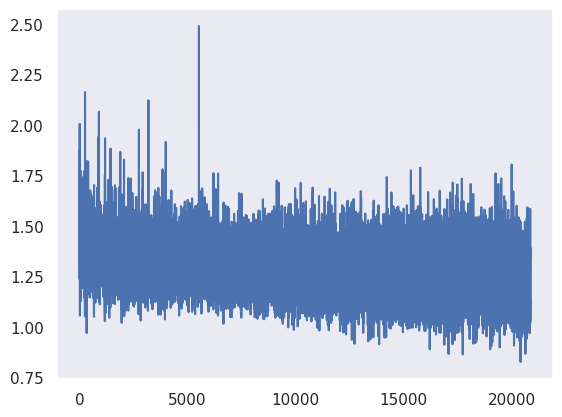

In [49]:
plt.plot(train_losses)

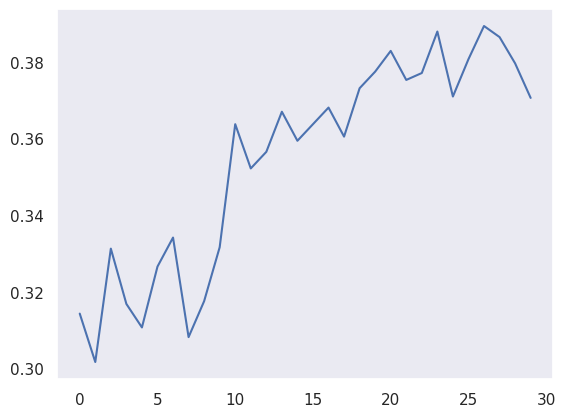

In [50]:
plt.plot(test_accuracy)

In [51]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

Correct: 1057/2768 (0.3819)
{'acc_detail': tensor([0.2835, 0.4055, 0.3434, 0.4630], device='cuda:0'),
 'acc_unweighted': tensor(0.3738, device='cuda:0'),
 'acc_weighted': tensor(0.3819, device='cuda:0'),
 'f1s': tensor(0.3753, device='cuda:0'),
 'f1s_detail': tensor([0.3154, 0.4070, 0.3703, 0.4084], device='cuda:0'),
 'precision_detail': tensor([0.3555, 0.4086, 0.4018, 0.3653], device='cuda:0'),
 'recall_detail': tensor([0.2835, 0.4055, 0.3434, 0.4630], device='cuda:0'),
 'rocauc': tensor([0.6711, 0.6375, 0.7343, 0.6335], device='cuda:0'),
 'uar': tensor(0.3738, device='cuda:0'),
 'wap': tensor(0.3825, device='cuda:0')}


tensor([[182, 122,  58, 280],
        [107, 324, 123, 245],
        [ 62, 170, 182, 116],
        [161, 177,  90, 369]], device='cuda:0')

In [52]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_msp4/msp4_m18_best_27epoch.pt
Correct: 1080/2768 (0.3902)
{'acc_detail': tensor([0.3629, 0.5044, 0.3019, 0.3563], device='cuda:0'),
 'acc_unweighted': tensor(0.3814, device='cuda:0'),
 'acc_weighted': tensor(0.3902, device='cuda:0'),
 'f1s': tensor(0.3823, device='cuda:0'),
 'f1s_detail': tensor([0.3661, 0.4402, 0.3463, 0.3767], device='cuda:0'),
 'precision_detail': tensor([0.3693, 0.3905, 0.4061, 0.3994], device='cuda:0'),
 'recall_detail': tensor([0.3629, 0.5044, 0.3019, 0.3563], device='cuda:0'),
 'rocauc': tensor([0.6750, 0.6312, 0.7362, 0.6283], device='cuda:0'),
 'uar': tensor(0.3814, device='cuda:0'),
 'wap': tensor(0.3911, device='cuda:0')}


tensor([[233, 168,  50, 191],
        [134, 403,  98, 164],
        [ 60, 238, 160,  72],
        [204, 223,  86, 284]], device='cuda:0')

In [53]:
checkpoint_path = '../models_msp4/msp4_m18_30epoch.ckpt'
torch.save({
    'epoch': 30,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [61]:
n_epoch = 10
n_epoch2 = 10
n_epoch3 = 10
n_epoch4 = 70

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+n_epoch+n_epoch2+n_epoch3, n_epoch4+n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                         | 0.0011547344110854503/70 [00:00<6:31:55, 335.94s/it]

Train Epoch: 31 [0/11092 (0%)]	Loss: 1.205564
Mem before-during-after: 38542848 3522419200 45123072


  0%|                           | 0.04734411085450344/70 [00:14<6:34:42, 338.55s/it]

Train Epoch: 31 [640/11092 (6%)]	Loss: 1.388095
Mem before-during-after: 45533696 3529165824 45263360


  0%|                           | 0.09353348729792137/70 [00:29<6:34:05, 338.24s/it]

Train Epoch: 31 [1280/11092 (12%)]	Loss: 1.288629
Mem before-during-after: 45533696 3529165824 45263360


  0%|                           | 0.13972286374133946/70 [00:43<6:34:40, 338.97s/it]

Train Epoch: 31 [1920/11092 (17%)]	Loss: 1.314334
Mem before-during-after: 45533696 3529165824 45263360


  0%|                           | 0.18591224018475794/70 [00:57<6:35:18, 339.74s/it]

Train Epoch: 31 [2560/11092 (23%)]	Loss: 1.266362
Mem before-during-after: 45533696 3529165824 45263360


  0%|                            | 0.2321016166281764/70 [01:11<6:38:26, 342.66s/it]

Train Epoch: 31 [3200/11092 (29%)]	Loss: 1.282136
Mem before-during-after: 45533696 3529165824 45263360


  0%|                            | 0.2782909930715942/70 [01:25<6:33:10, 338.36s/it]

Train Epoch: 31 [3840/11092 (35%)]	Loss: 1.239781
Mem before-during-after: 45533696 3529165824 45263360


  0%|▏                           | 0.3244803695150116/70 [01:40<6:41:57, 346.14s/it]

Train Epoch: 31 [4480/11092 (40%)]	Loss: 1.250654
Mem before-during-after: 45533696 3529165824 45263360


  1%|▏                          | 0.37066974595842894/70 [01:54<6:34:00, 339.51s/it]

Train Epoch: 31 [5120/11092 (46%)]	Loss: 1.144187
Mem before-during-after: 45533696 3529165824 45263360


  1%|▏                           | 0.4168591224018463/70 [02:08<6:38:22, 343.52s/it]

Train Epoch: 31 [5760/11092 (52%)]	Loss: 1.190908
Mem before-during-after: 45533696 3529165824 45263360


  1%|▏                          | 0.46304849884526367/70 [02:23<6:29:49, 336.36s/it]

Train Epoch: 31 [6400/11092 (58%)]	Loss: 1.115720
Mem before-during-after: 45533696 3529165824 45263360


  1%|▏                           | 0.5092378752886815/70 [02:37<6:52:54, 356.51s/it]

Train Epoch: 31 [7040/11092 (63%)]	Loss: 1.401802
Mem before-during-after: 45533696 3529165824 45263360


  1%|▏                           | 0.5554272517321011/70 [02:51<6:35:22, 341.60s/it]

Train Epoch: 31 [7680/11092 (69%)]	Loss: 1.321655
Mem before-during-after: 45533696 3529165824 45263360


  1%|▏                           | 0.6016166281755206/70 [03:06<6:44:33, 349.78s/it]

Train Epoch: 31 [8320/11092 (75%)]	Loss: 1.263505
Mem before-during-after: 45533696 3529165824 45263360


  1%|▎                           | 0.6478060046189402/70 [03:20<7:22:43, 383.03s/it]

Train Epoch: 31 [8960/11092 (81%)]	Loss: 1.239076
Mem before-during-after: 45533696 3529165824 45263360


  1%|▎                           | 0.6939953810623598/70 [03:35<6:38:45, 345.22s/it]

Train Epoch: 31 [9600/11092 (87%)]	Loss: 1.206699
Mem before-during-after: 45533696 3529165824 45263360


  1%|▎                           | 0.7401847575057794/70 [03:49<6:34:13, 341.52s/it]

Train Epoch: 31 [10240/11092 (92%)]	Loss: 1.257429
Mem before-during-after: 45533696 3529165824 45263360


  1%|▎                            | 0.786374133949199/70 [04:03<6:37:11, 344.31s/it]

Train Epoch: 31 [10880/11092 (98%)]	Loss: 1.369506
Mem before-during-after: 45533696 3529165824 45263360


  1%|▍                           | 1.0000000000000144/70 [04:48<3:46:10, 196.67s/it]


Test Epoch: 31	Accuracy: 1069/2768 (39%)



  1%|▍                           | 1.0011547344110998/70 [04:48<4:24:22, 229.89s/it]

Train Epoch: 32 [0/11092 (0%)]	Loss: 1.254951
Mem before-during-after: 45259264 3528895488 45256704


  1%|▍                            | 1.047344110854515/70 [05:02<6:28:43, 338.26s/it]

Train Epoch: 32 [640/11092 (6%)]	Loss: 1.253294
Mem before-during-after: 45256704 3529660928 45256704


  2%|▍                             | 1.09353348729793/70 [05:16<6:27:45, 337.63s/it]

Train Epoch: 32 [1280/11092 (12%)]	Loss: 1.181674
Mem before-during-after: 45256704 3529660928 45256704


  2%|▍                           | 1.1397228637413452/70 [05:31<6:30:37, 340.36s/it]

Train Epoch: 32 [1920/11092 (17%)]	Loss: 1.287297
Mem before-during-after: 45256704 3529660928 45256704


  2%|▍                           | 1.1859122401847604/70 [05:45<6:29:56, 339.99s/it]

Train Epoch: 32 [2560/11092 (23%)]	Loss: 1.136386
Mem before-during-after: 45256704 3529660928 45256704


  2%|▍                           | 1.2321016166281755/70 [05:59<6:30:06, 340.37s/it]

Train Epoch: 32 [3200/11092 (29%)]	Loss: 1.137670
Mem before-during-after: 45256704 3529660928 45256704


  2%|▌                           | 1.2782909930715907/70 [06:13<6:27:10, 338.03s/it]

Train Epoch: 32 [3840/11092 (35%)]	Loss: 1.257111
Mem before-during-after: 45256704 3529660928 45256704


  2%|▌                           | 1.3244803695150058/70 [06:28<6:37:56, 347.67s/it]

Train Epoch: 32 [4480/11092 (40%)]	Loss: 1.195850
Mem before-during-after: 45256704 3529660928 45256704


  2%|▌                            | 1.370669745958421/70 [06:42<6:46:52, 355.72s/it]

Train Epoch: 32 [5120/11092 (46%)]	Loss: 1.267839
Mem before-during-after: 45256704 3529660928 45256704


  2%|▌                            | 1.416859122401836/70 [06:57<6:25:31, 337.28s/it]

Train Epoch: 32 [5760/11092 (52%)]	Loss: 1.419804
Mem before-during-after: 45256704 3529660928 45256704


  2%|▌                           | 1.4630484988452512/70 [07:11<6:36:38, 347.24s/it]

Train Epoch: 32 [6400/11092 (58%)]	Loss: 1.156808
Mem before-during-after: 45256704 3529660928 45256704


  2%|▌                           | 1.5092378752886664/70 [07:25<6:25:18, 337.54s/it]

Train Epoch: 32 [7040/11092 (63%)]	Loss: 1.306273
Mem before-during-after: 45256704 3529660928 45256704


  2%|▌                           | 1.5554272517320815/70 [07:39<6:51:46, 360.97s/it]

Train Epoch: 32 [7680/11092 (69%)]	Loss: 1.214616
Mem before-during-after: 45256704 3529660928 45256704


  2%|▋                           | 1.6016166281754967/70 [07:54<6:27:46, 340.17s/it]

Train Epoch: 32 [8320/11092 (75%)]	Loss: 1.418229
Mem before-during-after: 45256704 3529660928 45256704


  2%|▋                           | 1.6478060046189118/70 [08:08<6:24:59, 337.95s/it]

Train Epoch: 32 [8960/11092 (81%)]	Loss: 1.350632
Mem before-during-after: 45256704 3529660928 45256704


  2%|▋                            | 1.693995381062327/70 [08:22<6:31:25, 343.82s/it]

Train Epoch: 32 [9600/11092 (87%)]	Loss: 2.612689
Mem before-during-after: 45256704 3529660928 45256704


  2%|▋                            | 1.740184757505742/70 [08:36<6:32:26, 344.96s/it]

Train Epoch: 32 [10240/11092 (92%)]	Loss: 1.170856
Mem before-during-after: 45256704 3529660928 45256704


  3%|▋                           | 1.7863741339491572/70 [08:51<6:30:13, 343.24s/it]

Train Epoch: 32 [10880/11092 (98%)]	Loss: 1.060587
Mem before-during-after: 45256704 3529660928 45256704


  3%|▊                           | 1.9999999999999523/70 [09:34<3:47:04, 200.37s/it]


Test Epoch: 32	Accuracy: 1025/2768 (37%)



  3%|▊                            | 2.001154734411038/70 [09:35<4:22:26, 231.57s/it]

Train Epoch: 33 [0/11092 (0%)]	Loss: 1.422851
Mem before-during-after: 45252608 3529309184 45256704


  3%|▊                            | 2.047344110854453/70 [09:49<6:33:49, 347.74s/it]

Train Epoch: 33 [640/11092 (6%)]	Loss: 1.298166
Mem before-during-after: 45256704 3529660928 45256704


  3%|▊                            | 2.093533487297868/70 [10:03<6:23:17, 338.66s/it]

Train Epoch: 33 [1280/11092 (12%)]	Loss: 1.165934
Mem before-during-after: 45256704 3529660928 45256704


  3%|▊                           | 2.1397228637412833/70 [10:17<6:20:56, 336.82s/it]

Train Epoch: 33 [1920/11092 (17%)]	Loss: 1.257562
Mem before-during-after: 45256704 3529660928 45256704


  3%|▊                           | 2.1859122401846984/70 [10:31<6:22:08, 338.11s/it]

Train Epoch: 33 [2560/11092 (23%)]	Loss: 1.442703
Mem before-during-after: 45256704 3529660928 45256704


  3%|▉                           | 2.2321016166281136/70 [10:46<9:45:46, 518.62s/it]

Train Epoch: 33 [3200/11092 (29%)]	Loss: 1.311773
Mem before-during-after: 45256704 3529660928 45256704


  3%|▉                           | 2.2782909930715287/70 [11:13<7:54:00, 419.96s/it]

Train Epoch: 33 [3840/11092 (35%)]	Loss: 1.418985
Mem before-during-after: 45256704 3529660928 45256704


  3%|▉                            | 2.324480369514944/70 [11:27<6:20:32, 337.38s/it]

Train Epoch: 33 [4480/11092 (40%)]	Loss: 1.278681
Mem before-during-after: 45256704 3529660928 45256704


  3%|▉                            | 2.370669745958359/70 [11:41<6:37:30, 352.66s/it]

Train Epoch: 33 [5120/11092 (46%)]	Loss: 1.178125
Mem before-during-after: 45256704 3529660928 45256704


  3%|█                            | 2.416859122401774/70 [11:56<6:19:45, 337.15s/it]

Train Epoch: 33 [5760/11092 (52%)]	Loss: 1.302224
Mem before-during-after: 45256704 3529660928 45256704


  4%|▉                           | 2.4630484988451893/70 [12:10<6:20:28, 338.01s/it]

Train Epoch: 33 [6400/11092 (58%)]	Loss: 1.215989
Mem before-during-after: 45256704 3529660928 45256704


  4%|█                           | 2.5092378752886044/70 [12:25<6:21:40, 339.32s/it]

Train Epoch: 33 [7040/11092 (63%)]	Loss: 1.203069
Mem before-during-after: 45256704 3529660928 45256704


  4%|█                           | 2.5554272517320196/70 [12:39<7:03:52, 377.08s/it]

Train Epoch: 33 [7680/11092 (69%)]	Loss: 1.319998
Mem before-during-after: 45256704 3529660928 45256704


  4%|█                           | 2.6016166281754347/70 [12:53<6:19:38, 337.97s/it]

Train Epoch: 33 [8320/11092 (75%)]	Loss: 1.540537
Mem before-during-after: 45256704 3529660928 45256704


  4%|█▏                            | 2.64780600461885/70 [13:08<6:16:18, 335.24s/it]

Train Epoch: 33 [8960/11092 (81%)]	Loss: 1.413294
Mem before-during-after: 45256704 3529660928 45256704


  4%|█                            | 2.693995381062265/70 [13:22<6:23:32, 341.92s/it]

Train Epoch: 33 [9600/11092 (87%)]	Loss: 1.219613
Mem before-during-after: 45256704 3529660928 45256704


  4%|█▏                            | 2.74018475750568/70 [13:36<6:22:48, 341.49s/it]

Train Epoch: 33 [10240/11092 (92%)]	Loss: 1.307428
Mem before-during-after: 45256704 3529660928 45256704


  4%|█                           | 2.7863741339490953/70 [13:50<6:18:04, 337.50s/it]

Train Epoch: 33 [10880/11092 (98%)]	Loss: 1.519793
Mem before-during-after: 45256704 3529660928 45256704


  4%|█▏                          | 2.9999999999998903/70 [14:35<3:50:12, 206.15s/it]


Test Epoch: 33	Accuracy: 1021/2768 (37%)



  4%|█▏                          | 3.0011547344109757/70 [14:35<4:23:34, 236.05s/it]

Train Epoch: 34 [0/11092 (0%)]	Loss: 1.288681
Mem before-during-after: 45252608 3529309184 45256704


  4%|█▎                           | 3.047344110854391/70 [14:49<6:17:22, 338.19s/it]

Train Epoch: 34 [640/11092 (6%)]	Loss: 1.273869
Mem before-during-after: 45256704 3529660928 45256704


  4%|█▎                           | 3.093533487297806/70 [15:03<6:17:57, 338.94s/it]

Train Epoch: 34 [1280/11092 (12%)]	Loss: 1.427496
Mem before-during-after: 45256704 3529660928 45256704


  4%|█▎                           | 3.139722863741221/70 [15:18<6:18:34, 339.73s/it]

Train Epoch: 34 [1920/11092 (17%)]	Loss: 1.129003
Mem before-during-after: 45256704 3529660928 45256704


  5%|█▎                          | 3.1859122401846363/70 [15:32<6:16:12, 337.84s/it]

Train Epoch: 34 [2560/11092 (23%)]	Loss: 1.362384
Mem before-during-after: 45256704 3529660928 45256704


  5%|█▎                          | 3.2321016166280514/70 [15:46<6:25:16, 346.22s/it]

Train Epoch: 34 [3200/11092 (29%)]	Loss: 1.281380
Mem before-during-after: 45256704 3529660928 45256704


  5%|█▎                          | 3.2782909930714665/70 [16:00<6:27:49, 348.75s/it]

Train Epoch: 34 [3840/11092 (35%)]	Loss: 1.290541
Mem before-during-after: 45256704 3529660928 45256704


  5%|█▎                          | 3.3244803695148817/70 [16:14<6:21:06, 342.96s/it]

Train Epoch: 34 [4480/11092 (40%)]	Loss: 1.051810
Mem before-during-after: 45256704 3529660928 45256704


  5%|█▍                           | 3.370669745958297/70 [16:29<6:15:34, 338.20s/it]

Train Epoch: 34 [5120/11092 (46%)]	Loss: 1.126568
Mem before-during-after: 45256704 3529660928 45256704


  5%|█▍                           | 3.416859122401712/70 [16:43<6:10:21, 333.75s/it]

Train Epoch: 34 [5760/11092 (52%)]	Loss: 1.168998
Mem before-during-after: 45256704 3529660928 45256704


  5%|█▍                           | 3.463048498845127/70 [16:57<6:14:35, 337.79s/it]

Train Epoch: 34 [6400/11092 (58%)]	Loss: 1.336050
Mem before-during-after: 45256704 3529660928 45256704


  5%|█▍                          | 3.5092378752885423/70 [17:12<8:41:26, 470.53s/it]

Train Epoch: 34 [7040/11092 (63%)]	Loss: 1.370007
Mem before-during-after: 45256704 3529660928 45256704


  5%|█▎                         | 3.5554272517319574/70 [17:38<11:32:42, 625.53s/it]

Train Epoch: 34 [7680/11092 (69%)]	Loss: 1.172209
Mem before-during-after: 45256704 3529660928 45256704


  5%|█▍                          | 3.6016166281753725/70 [17:54<6:15:51, 339.64s/it]

Train Epoch: 34 [8320/11092 (75%)]	Loss: 1.204224
Mem before-during-after: 45256704 3529660928 45256704


  5%|█▍                          | 3.6478060046187877/70 [18:09<6:11:04, 335.55s/it]

Train Epoch: 34 [8960/11092 (81%)]	Loss: 1.459835
Mem before-during-after: 45256704 3529660928 45256704


  5%|█▌                           | 3.693995381062203/70 [18:23<6:23:15, 346.82s/it]

Train Epoch: 34 [9600/11092 (87%)]	Loss: 1.254432
Mem before-during-after: 45256704 3529660928 45256704


  5%|█▌                           | 3.740184757505618/70 [18:38<6:20:25, 344.48s/it]

Train Epoch: 34 [10240/11092 (92%)]	Loss: 1.360792
Mem before-during-after: 45256704 3529660928 45256704


  5%|█▌                           | 3.786374133949033/70 [18:52<6:12:28, 337.52s/it]

Train Epoch: 34 [10880/11092 (98%)]	Loss: 1.029304
Mem before-during-after: 45256704 3529660928 45256704


  6%|█▋                           | 3.999999999999828/70 [19:37<3:37:14, 197.49s/it]


Test Epoch: 34	Accuracy: 1025/2768 (37%)



  6%|█▋                           | 4.001154734410914/70 [19:37<4:21:28, 237.71s/it]

Train Epoch: 35 [0/11092 (0%)]	Loss: 1.197045
Mem before-during-after: 45252608 3529309184 45256704


  6%|█▋                           | 4.047344110854329/70 [19:51<6:13:44, 340.00s/it]

Train Epoch: 35 [640/11092 (6%)]	Loss: 1.395087
Mem before-during-after: 45256704 3529660928 45256704


  6%|█▋                           | 4.093533487297744/70 [20:05<6:12:51, 339.44s/it]

Train Epoch: 35 [1280/11092 (12%)]	Loss: 1.311103
Mem before-during-after: 45256704 3529660928 45256704


  6%|█▋                           | 4.139722863741159/70 [20:20<6:11:27, 338.41s/it]

Train Epoch: 35 [1920/11092 (17%)]	Loss: 1.070837
Mem before-during-after: 45256704 3529660928 45256704


  6%|█▋                          | 4.1859122401845745/70 [20:34<6:19:45, 346.21s/it]

Train Epoch: 35 [2560/11092 (23%)]	Loss: 1.246993
Mem before-during-after: 45256704 3529660928 45256704


  6%|█▊                            | 4.23210161662799/70 [20:48<6:13:53, 341.11s/it]

Train Epoch: 35 [3200/11092 (29%)]	Loss: 1.287277
Mem before-during-after: 45256704 3529660928 45256704


  6%|█▊                           | 4.278290993071405/70 [21:02<6:09:55, 337.72s/it]

Train Epoch: 35 [3840/11092 (35%)]	Loss: 1.398314
Mem before-during-after: 45256704 3529660928 45256704


  6%|█▊                            | 4.32448036951482/70 [21:16<6:10:27, 338.44s/it]

Train Epoch: 35 [4480/11092 (40%)]	Loss: 1.302759
Mem before-during-after: 45256704 3529660928 45256704


  6%|█▊                           | 4.370669745958235/70 [21:31<6:13:24, 341.38s/it]

Train Epoch: 35 [5120/11092 (46%)]	Loss: 1.058974
Mem before-during-after: 45256704 3529660928 45256704


  6%|█▉                            | 4.41685912240165/70 [21:45<6:09:23, 337.95s/it]

Train Epoch: 35 [5760/11092 (52%)]	Loss: 1.171402
Mem before-during-after: 45256704 3529660928 45256704


  6%|█▊                           | 4.463048498845065/70 [21:59<6:22:29, 350.18s/it]

Train Epoch: 35 [6400/11092 (58%)]	Loss: 1.375388
Mem before-during-after: 45256704 3529660928 45256704


  6%|█▊                          | 4.5092378752884805/70 [22:13<6:09:23, 338.41s/it]

Train Epoch: 35 [7040/11092 (63%)]	Loss: 1.132888
Mem before-during-after: 45256704 3529660928 45256704


  7%|█▉                           | 4.555427251731896/70 [22:28<6:11:08, 340.27s/it]

Train Epoch: 35 [7680/11092 (69%)]	Loss: 1.205256
Mem before-during-after: 45256704 3529660928 45256704


  7%|█▉                           | 4.601616628175311/70 [22:42<6:07:40, 337.33s/it]

Train Epoch: 35 [8320/11092 (75%)]	Loss: 1.439154
Mem before-during-after: 45256704 3529660928 45256704


  7%|█▉                           | 4.647806004618726/70 [22:56<6:18:22, 347.38s/it]

Train Epoch: 35 [8960/11092 (81%)]	Loss: 1.330449
Mem before-during-after: 45256704 3529660928 45256704


  7%|█▉                           | 4.693995381062141/70 [23:10<6:12:41, 342.42s/it]

Train Epoch: 35 [9600/11092 (87%)]	Loss: 1.154333
Mem before-during-after: 45256704 3529660928 45256704


  7%|█▉                           | 4.740184757505556/70 [23:25<6:14:37, 344.43s/it]

Train Epoch: 35 [10240/11092 (92%)]	Loss: 1.249170
Mem before-during-after: 45256704 3529660928 45256704


  7%|█▉                           | 4.786374133948971/70 [23:40<6:11:26, 341.75s/it]

Train Epoch: 35 [10880/11092 (98%)]	Loss: 1.357444
Mem before-during-after: 45256704 3529660928 45256704


  7%|██                           | 4.999999999999766/70 [24:24<3:28:04, 192.07s/it]


Test Epoch: 35	Accuracy: 1010/2768 (36%)



  7%|██                           | 5.001154734410852/70 [24:24<4:07:31, 228.49s/it]

Train Epoch: 36 [0/11092 (0%)]	Loss: 1.207773
Mem before-during-after: 45252608 3529309184 45256704


  7%|██                           | 5.047344110854267/70 [24:38<6:19:13, 350.31s/it]

Train Epoch: 36 [640/11092 (6%)]	Loss: 1.092806
Mem before-during-after: 45256704 3529660928 45256704


  7%|██                           | 5.093533487297682/70 [24:53<6:07:32, 339.76s/it]

Train Epoch: 36 [1280/11092 (12%)]	Loss: 1.259492
Mem before-during-after: 45256704 3529660928 45256704


  7%|██▏                          | 5.139722863741097/70 [25:07<6:06:16, 338.83s/it]

Train Epoch: 36 [1920/11092 (17%)]	Loss: 1.467452
Mem before-during-after: 45256704 3529660928 45256704


  7%|██▏                          | 5.185912240184512/70 [25:21<6:02:17, 335.38s/it]

Train Epoch: 36 [2560/11092 (23%)]	Loss: 1.081612
Mem before-during-after: 45256704 3529660928 45256704


  7%|██                          | 5.2321016166279275/70 [25:35<6:01:25, 334.81s/it]

Train Epoch: 36 [3200/11092 (29%)]	Loss: 1.171709
Mem before-during-after: 45256704 3529660928 45256704


  8%|██▏                          | 5.278290993071343/70 [25:50<6:13:21, 346.12s/it]

Train Epoch: 36 [3840/11092 (35%)]	Loss: 1.271191
Mem before-during-after: 45256704 3529660928 45256704


  8%|██▏                          | 5.324480369514758/70 [26:04<6:11:30, 344.66s/it]

Train Epoch: 36 [4480/11092 (40%)]	Loss: 1.343243
Mem before-during-after: 45256704 3529660928 45256704


  8%|██▏                          | 5.370669745958173/70 [26:18<6:04:55, 338.78s/it]

Train Epoch: 36 [5120/11092 (46%)]	Loss: 1.216547
Mem before-during-after: 45256704 3529660928 45256704


  8%|██▏                          | 5.416859122401588/70 [26:32<6:26:38, 359.20s/it]

Train Epoch: 36 [5760/11092 (52%)]	Loss: 1.380233
Mem before-during-after: 45256704 3529660928 45256704


  8%|██▎                          | 5.463048498845003/70 [26:46<6:06:51, 341.06s/it]

Train Epoch: 36 [6400/11092 (58%)]	Loss: 1.178092
Mem before-during-after: 45256704 3529660928 45256704


  8%|██▎                          | 5.509237875288418/70 [27:01<6:12:38, 346.69s/it]

Train Epoch: 36 [7040/11092 (63%)]	Loss: 1.201058
Mem before-during-after: 45256704 3529660928 45256704


  8%|██▏                         | 5.5554272517318335/70 [27:15<6:16:31, 350.56s/it]

Train Epoch: 36 [7680/11092 (69%)]	Loss: 1.233730
Mem before-during-after: 45256704 3529660928 45256704


  8%|██▎                          | 5.601616628175249/70 [27:29<6:00:47, 336.14s/it]

Train Epoch: 36 [8320/11092 (75%)]	Loss: 1.246635
Mem before-during-after: 45256704 3529660928 45256704


  8%|██▎                          | 5.647806004618664/70 [27:43<6:03:05, 338.53s/it]

Train Epoch: 36 [8960/11092 (81%)]	Loss: 1.348500
Mem before-during-after: 45256704 3529660928 45256704


  8%|██▎                          | 5.693995381062079/70 [27:58<6:03:25, 339.09s/it]

Train Epoch: 36 [9600/11092 (87%)]	Loss: 1.081651
Mem before-during-after: 45256704 3529660928 45256704


  8%|██▍                          | 5.740184757505494/70 [28:12<5:59:31, 335.69s/it]

Train Epoch: 36 [10240/11092 (92%)]	Loss: 1.257050
Mem before-during-after: 45256704 3529660928 45256704


  8%|██▍                          | 5.786374133948909/70 [28:26<5:58:41, 335.16s/it]

Train Epoch: 36 [10880/11092 (98%)]	Loss: 1.546395
Mem before-during-after: 45256704 3529660928 45256704


  9%|██▍                          | 5.999999999999704/70 [29:10<3:32:52, 199.57s/it]


Test Epoch: 36	Accuracy: 1017/2768 (37%)



  9%|██▌                           | 6.00115473441079/70 [29:10<4:10:05, 234.47s/it]

Train Epoch: 37 [0/11092 (0%)]	Loss: 1.299776
Mem before-during-after: 45252608 3529309184 45256704


  9%|██▌                          | 6.047344110854205/70 [29:25<5:58:34, 336.42s/it]

Train Epoch: 37 [640/11092 (6%)]	Loss: 1.263708
Mem before-during-after: 45256704 3529660928 45256704


  9%|██▌                           | 6.09353348729762/70 [29:39<6:02:13, 340.08s/it]

Train Epoch: 37 [1280/11092 (12%)]	Loss: 1.238198
Mem before-during-after: 45256704 3529660928 45256704


  9%|██▌                          | 6.139722863741035/70 [29:53<5:58:18, 336.65s/it]

Train Epoch: 37 [1920/11092 (17%)]	Loss: 1.306842
Mem before-during-after: 45256704 3529660928 45256704


  9%|██▋                           | 6.18591224018445/70 [30:07<6:00:12, 338.67s/it]

Train Epoch: 37 [2560/11092 (23%)]	Loss: 1.126290
Mem before-during-after: 45256704 3529660928 45256704


  9%|██▌                          | 6.232101616627865/70 [30:22<6:03:27, 341.99s/it]

Train Epoch: 37 [3200/11092 (29%)]	Loss: 1.267526
Mem before-during-after: 45256704 3529660928 45256704


  9%|██▌                         | 6.2782909930712805/70 [30:36<6:02:12, 341.06s/it]

Train Epoch: 37 [3840/11092 (35%)]	Loss: 1.186138
Mem before-during-after: 45256704 3529660928 45256704


  9%|██▌                          | 6.324480369514696/70 [30:50<6:05:52, 344.75s/it]

Train Epoch: 37 [4480/11092 (40%)]	Loss: 1.210754
Mem before-during-after: 45256704 3529660928 45256704


  9%|██▋                          | 6.370669745958111/70 [31:05<6:20:17, 358.60s/it]

Train Epoch: 37 [5120/11092 (46%)]	Loss: 1.433978
Mem before-during-after: 45256704 3529660928 45256704


  9%|██▋                          | 6.416859122401526/70 [31:19<5:59:25, 339.16s/it]

Train Epoch: 37 [5760/11092 (52%)]	Loss: 1.392555
Mem before-during-after: 45256704 3529660928 45256704


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f092c1d2190>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  9%|██▋                          | 6.418013856812611/70 [31:20<5:40:12, 321.04s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f092c1d2190>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  9%|██▋                          | 6.418013856812611/70 [31:20<5:10:29, 293.00s/it]


KeyboardInterrupt: 

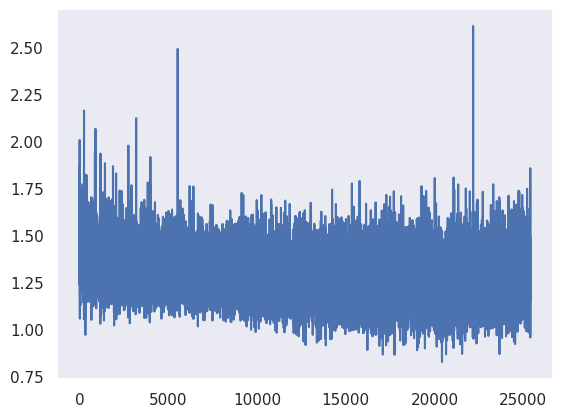

In [62]:
plt.plot(train_losses)

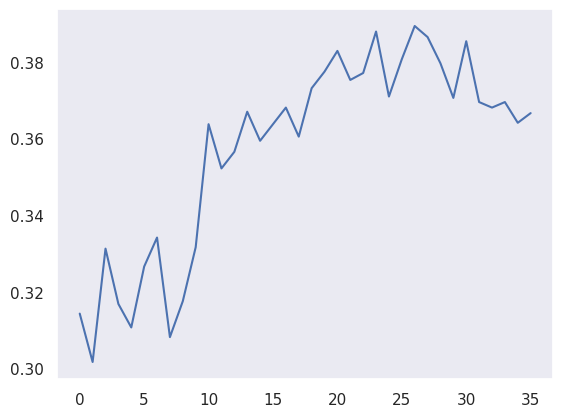

In [63]:
plt.plot(test_accuracy)

In [64]:
blayer = best_model.fe_blocks.blocks[0].block.layer

bnamed_params = [p for p in blayer.named_parameters()]
bnamed_params

[('lowcut_bands',
  Parameter containing:
  tensor([[0.0000],
          [0.0026],
          [0.0054],
          [0.0084],
          [0.0116],
          [0.0149],
          [0.0184],
          [0.0222],
          [0.0262],
          [0.0304],
          [0.0349],
          [0.0396],
          [0.0446],
          [0.0500],
          [0.0556],
          [0.0616],
          [0.0680],
          [0.0747],
          [0.0819],
          [0.0895],
          [0.0975],
          [0.1060],
          [0.1151],
          [0.1247],
          [0.1348],
          [0.1456],
          [0.1570],
          [0.1691],
          [0.1820],
          [0.1956],
          [0.2101],
          [0.2254],
          [0.2416],
          [0.2589],
          [0.2771],
          [0.2965],
          [0.3170],
          [0.3388],
          [0.3619],
          [0.3864],
          [0.4123],
          [0.4399],
          [0.4690],
          [0.0000],
          [0.0040],
          [0.0081],
          [0.0124],
          [0.0170]

Time domain: Filters' shapes vary by frequency bins


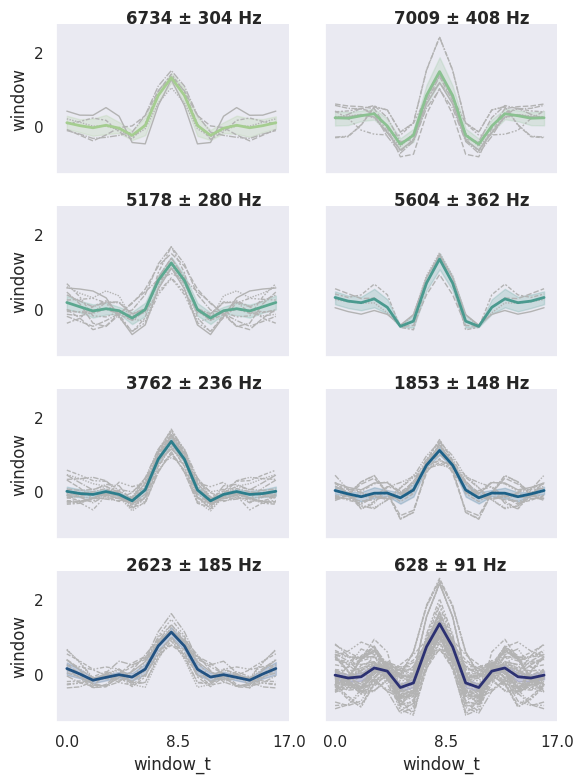

In [65]:
bfiltviz = visualize_model.FilterVisualizer(
    lowcut_bands = blayer.lowcut_bands, 
    bandwidths = blayer.bandwidths,
    window_params = blayer.window_params, 
    window_length = 64,
    sample_rate = sr
)
bfiltviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


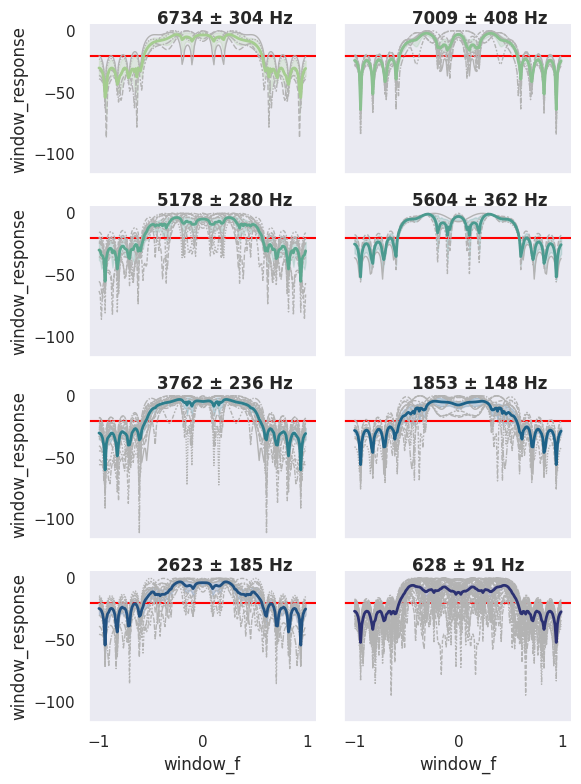

In [66]:
bfiltviz.visualize_filters(filter_domain='freq')

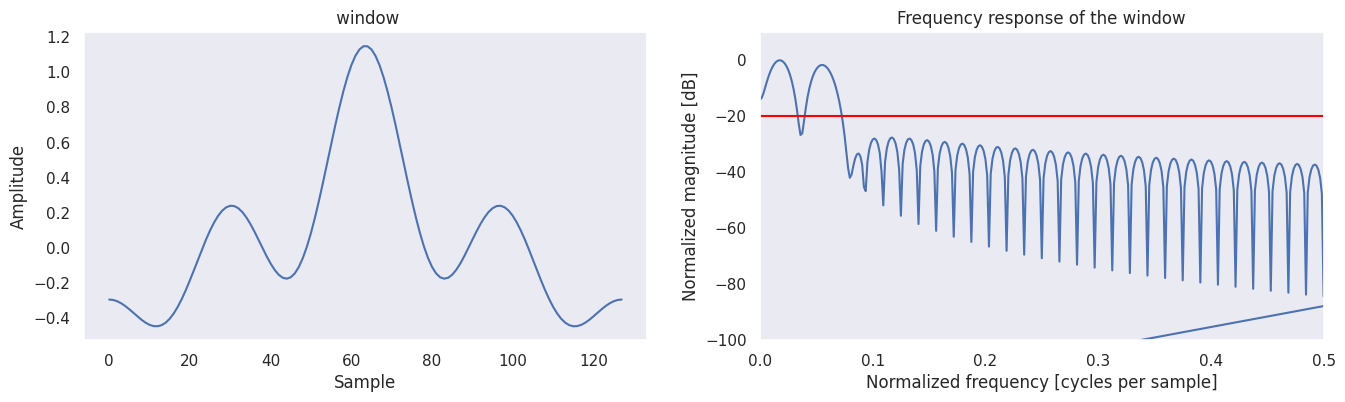

In [67]:
bfiltviz.visualize_one_window(n_out=10)

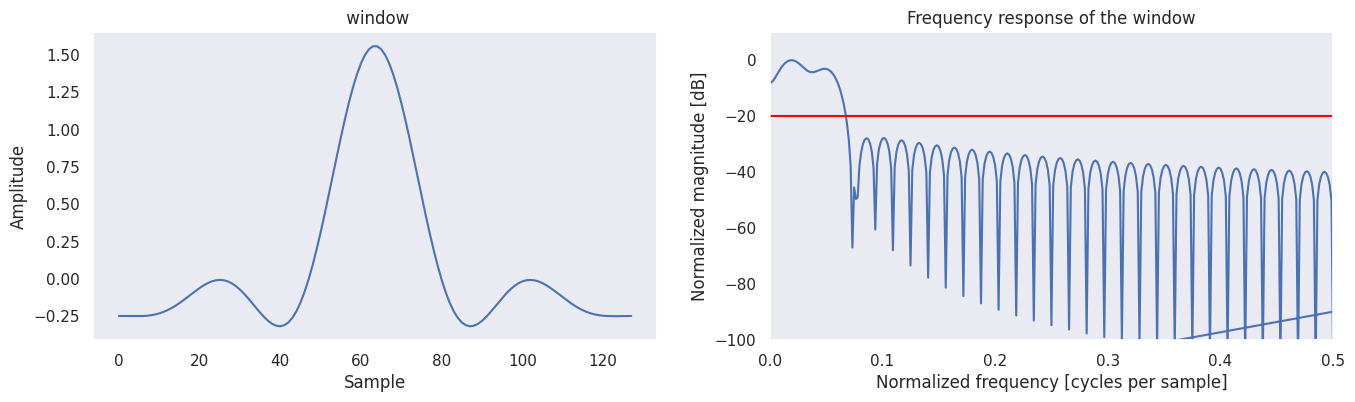

In [68]:
bfiltviz.visualize_one_window(n_out=30)

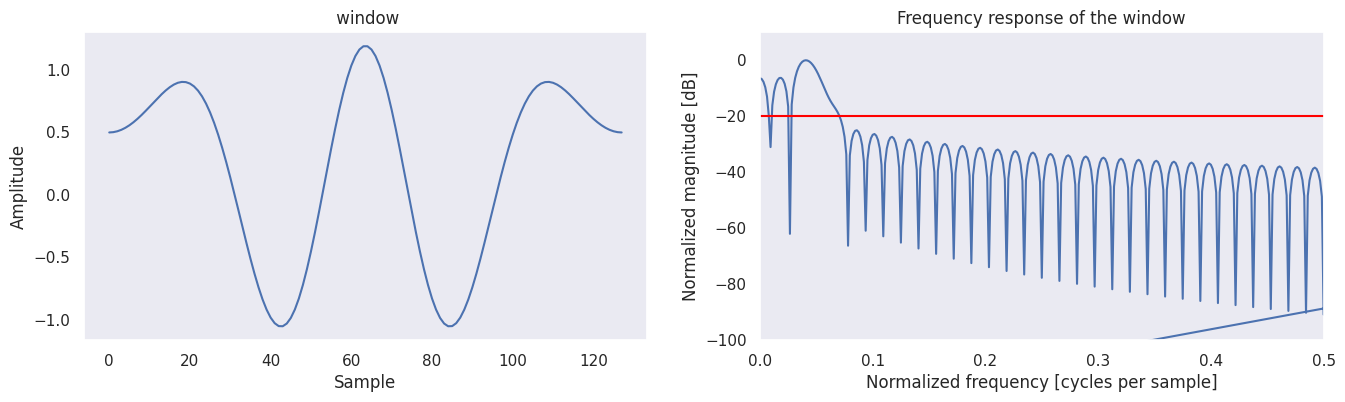

In [69]:
bfiltviz.visualize_one_window(n_out=50)

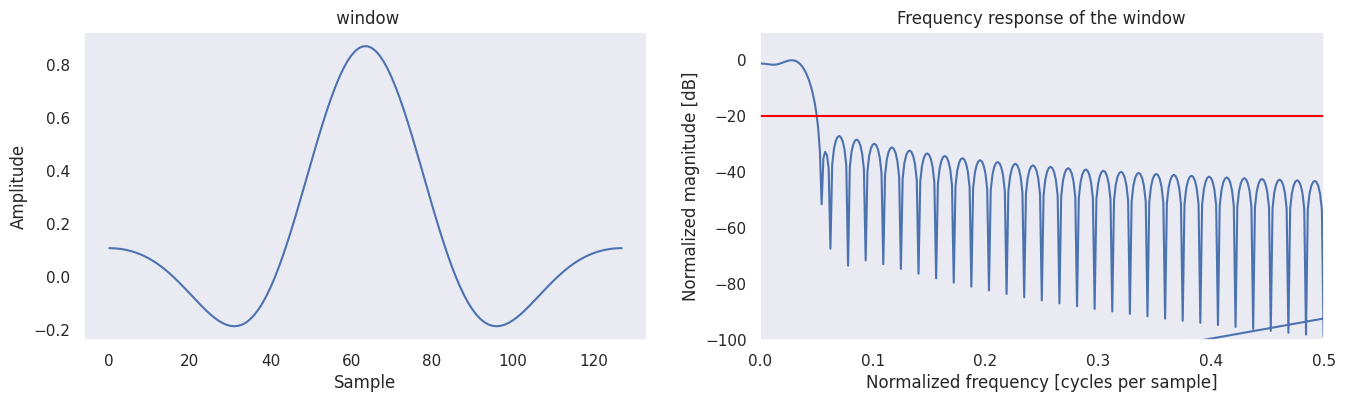

In [70]:
bfiltviz.visualize_one_window(n_out=60)